In [1]:
import pandas as pd
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from random import random
from io_utils import *

In [2]:
from LightCurve import LightCurve

In [3]:
data_ob = load_RESSPECT_data()
object_ids = data_ob.get_all_object_ids()

In [4]:
data_ob.df_metadata

SNID,redshift,type,code,sample
float64,float64,str10,float64,str5
6612.0,0.41613463,II_V19,42.0,train
7860.0,0.23487686,II-NMF,42.0,train
3421.0,0.14118282,II-NMF,42.0,train
3368.0,0.26212534,II-NMF,42.0,train
3200.0,0.47726378,II_V19,42.0,train
2478.0,0.5132554,II_V19,42.0,train
1640.0,0.20038009,IIn,42.0,train
6509.0,0.2553885,II_V19,42.0,train
2002.0,0.2602583,II_V19,42.0,train


In [5]:
color_band_dict = {'u':'C4','g':'C2', 'r':'C3', 'i':'C1', 'z':'k', 'Y':'C5'}

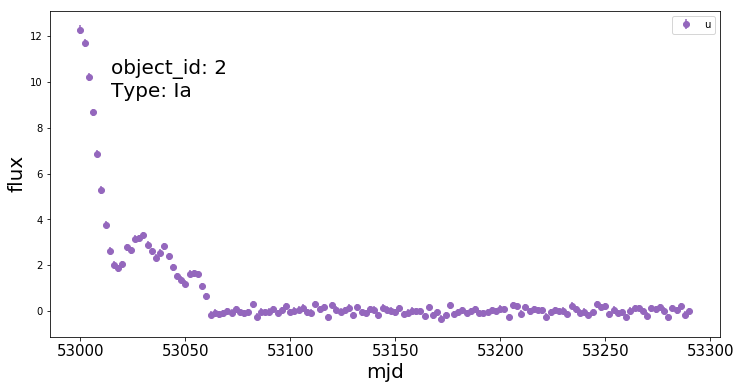

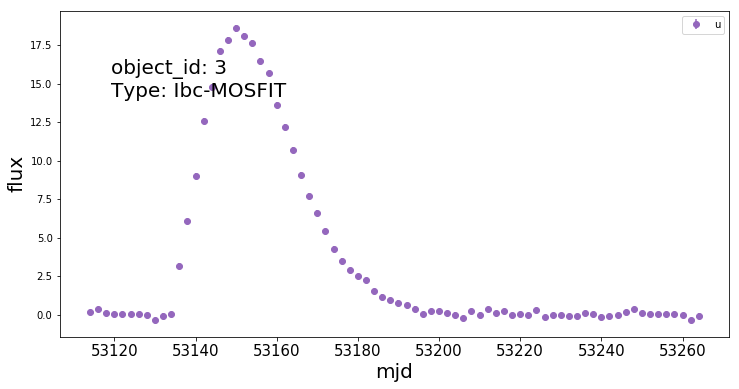

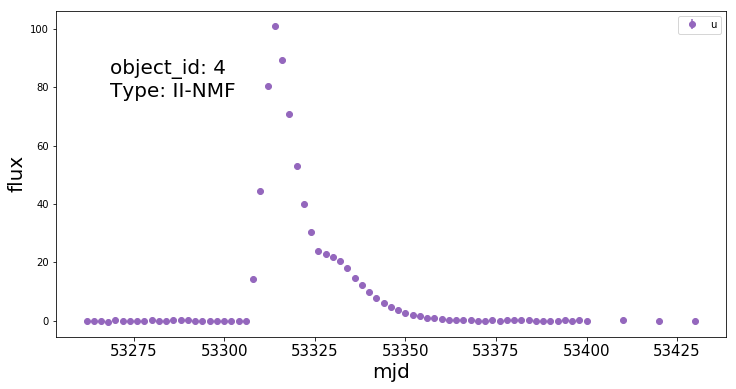

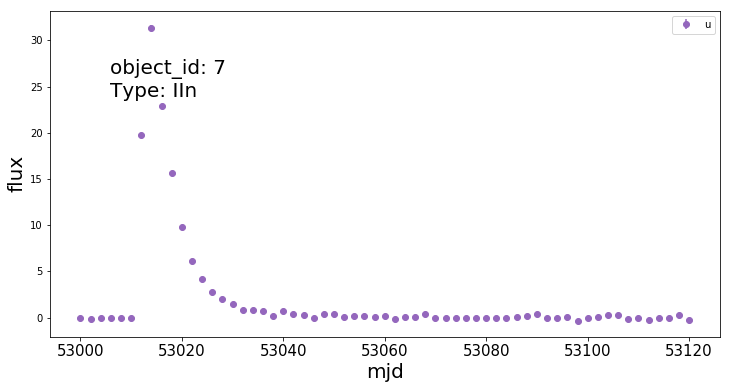

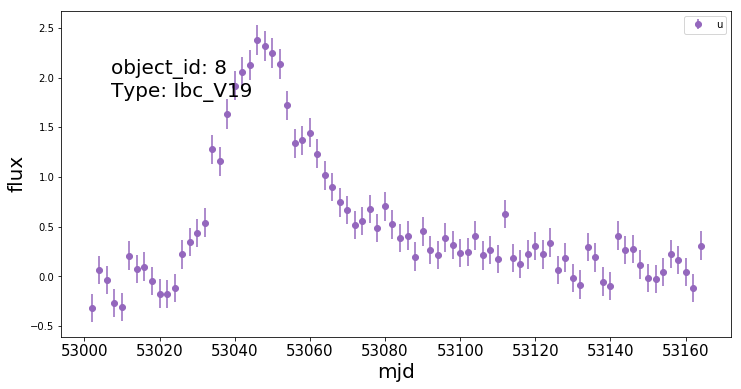

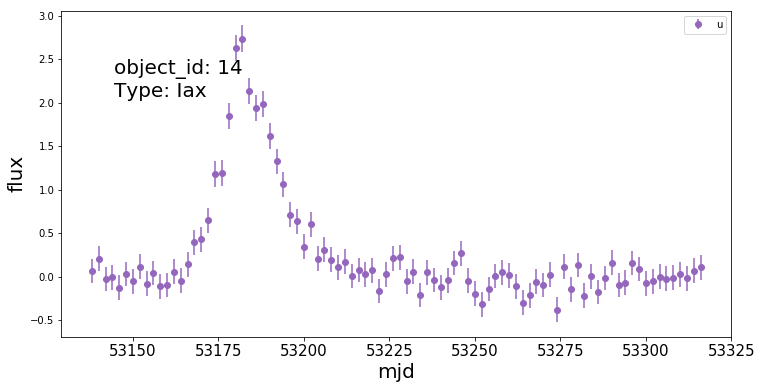

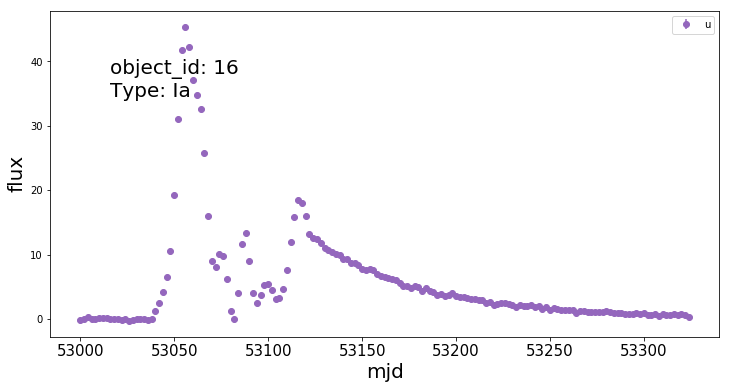

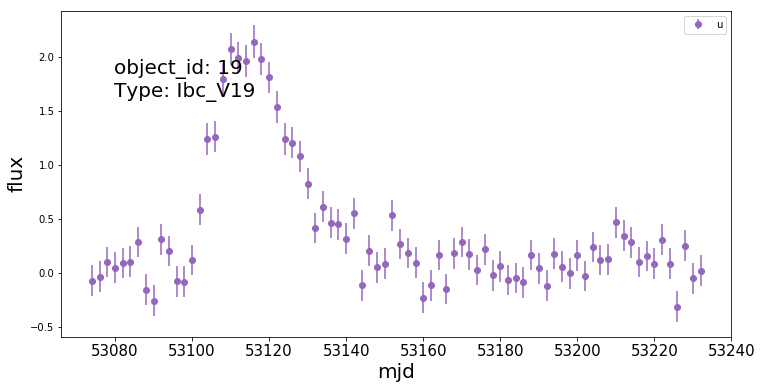

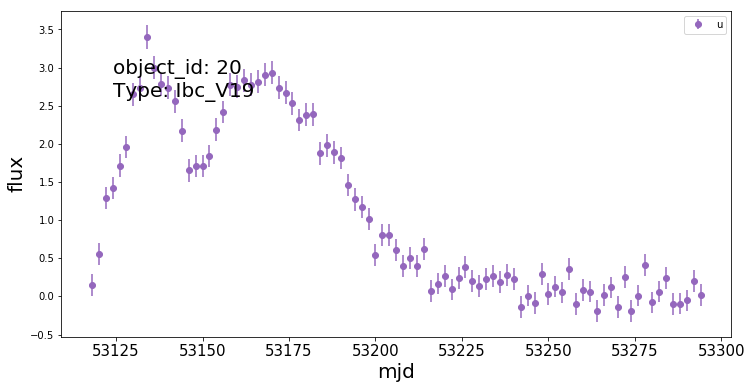

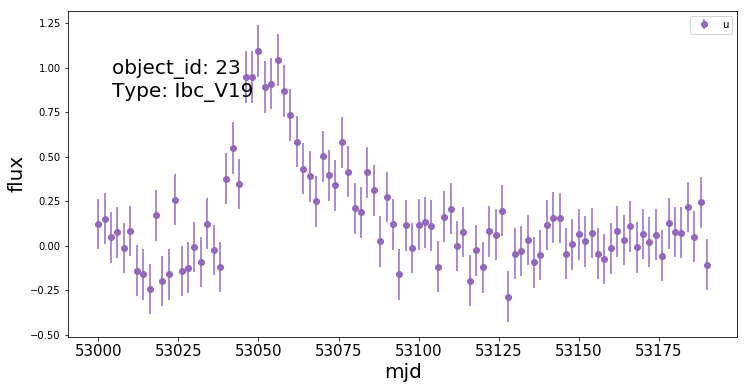

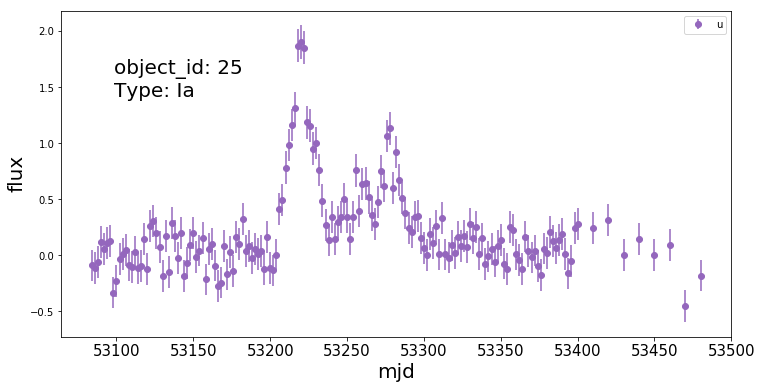

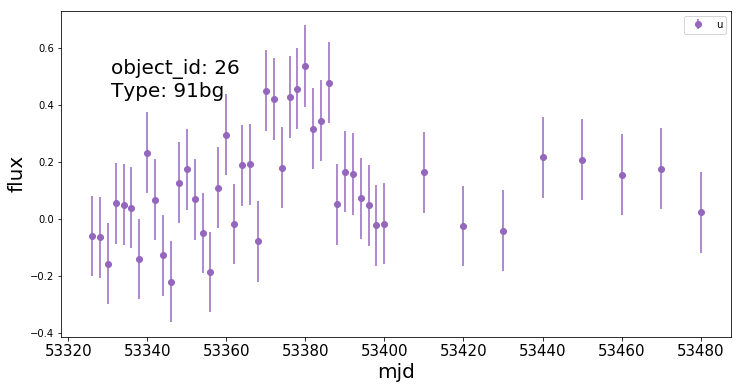

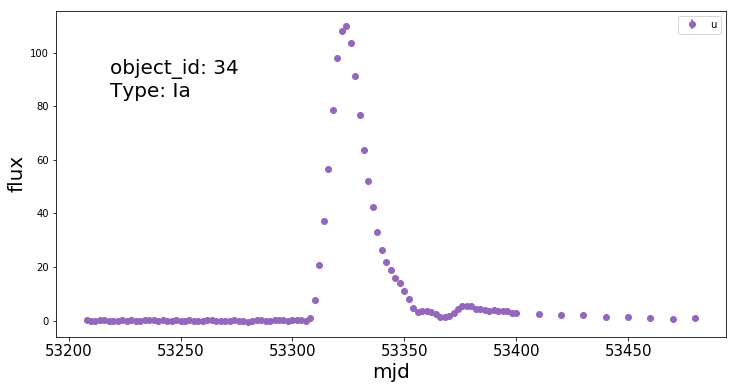

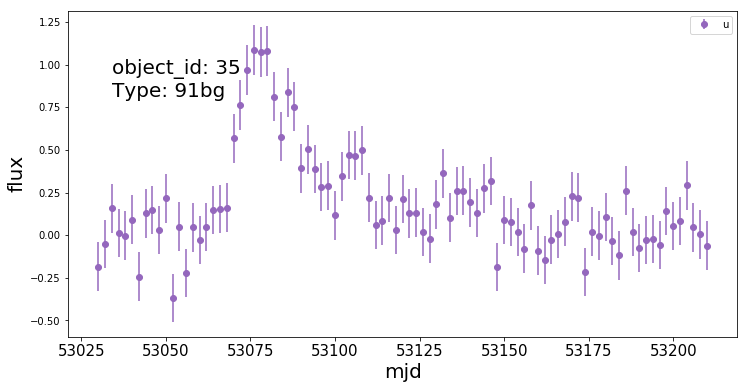

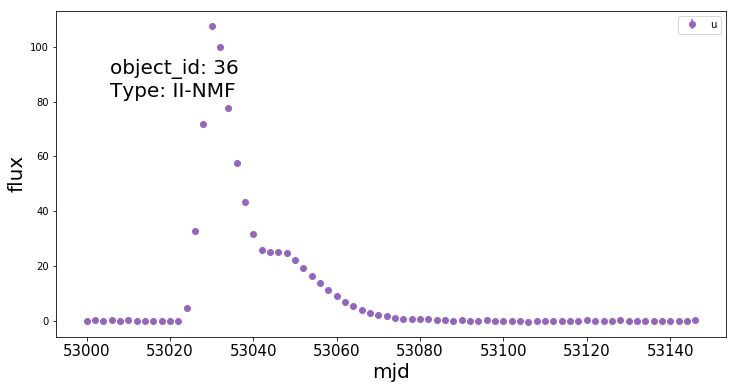

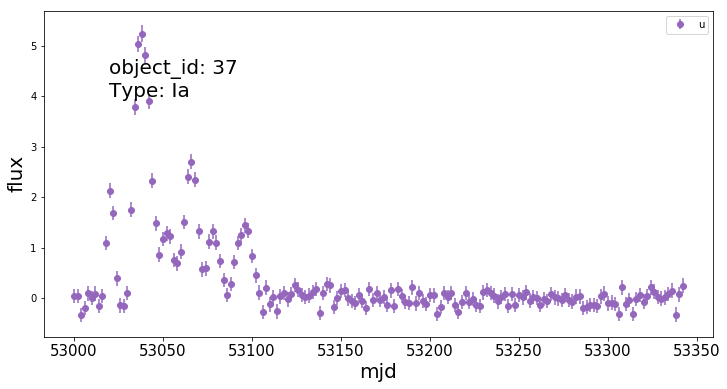

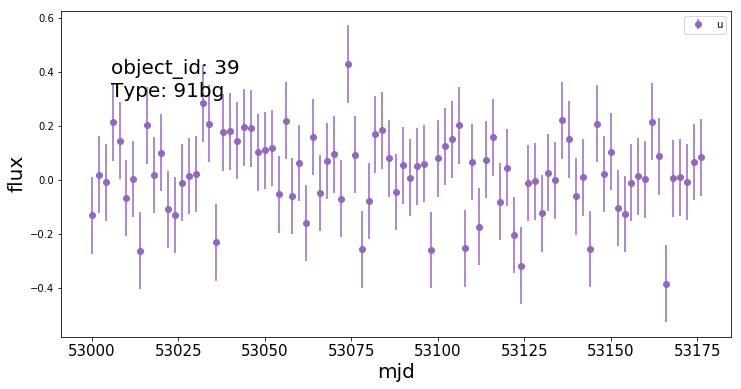

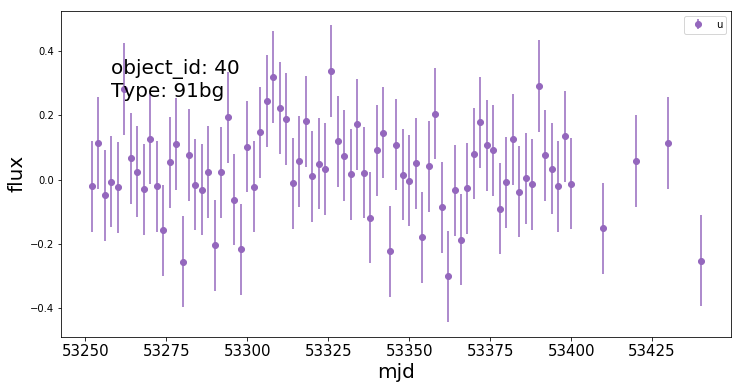

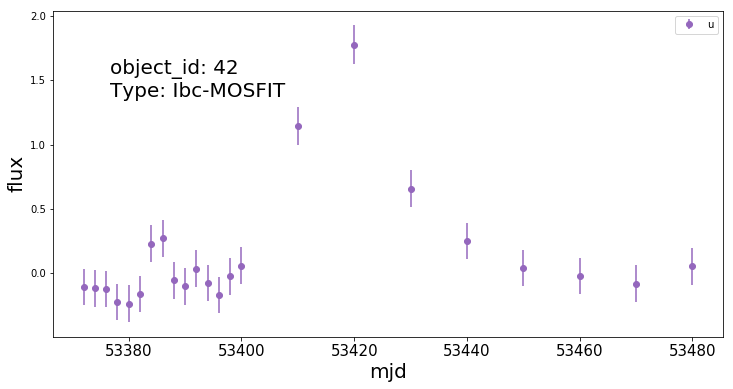

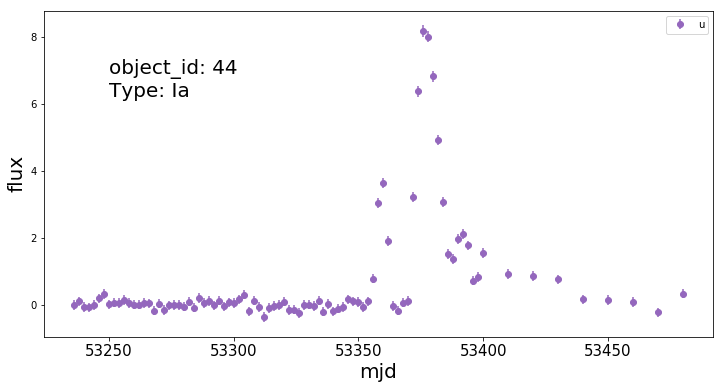

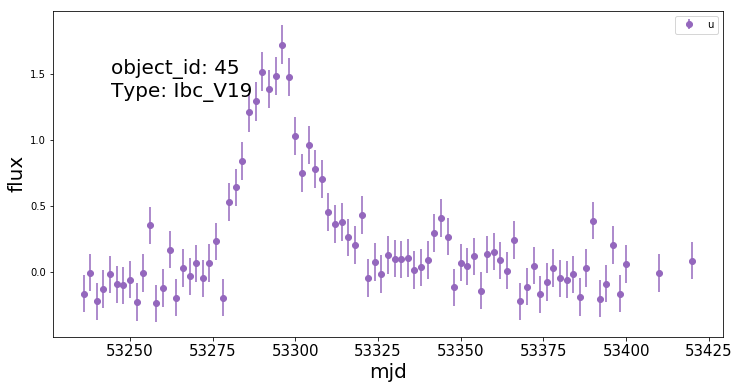

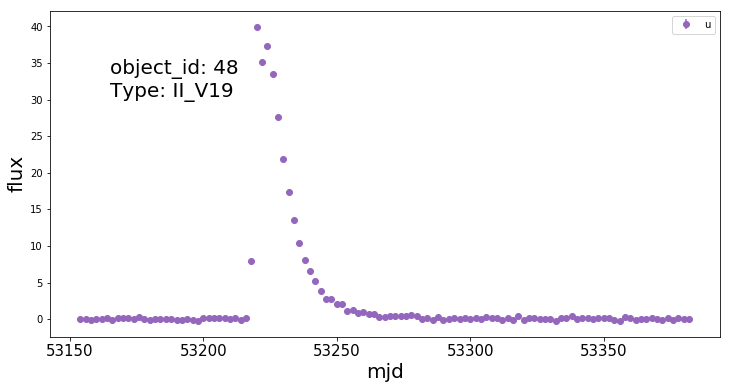

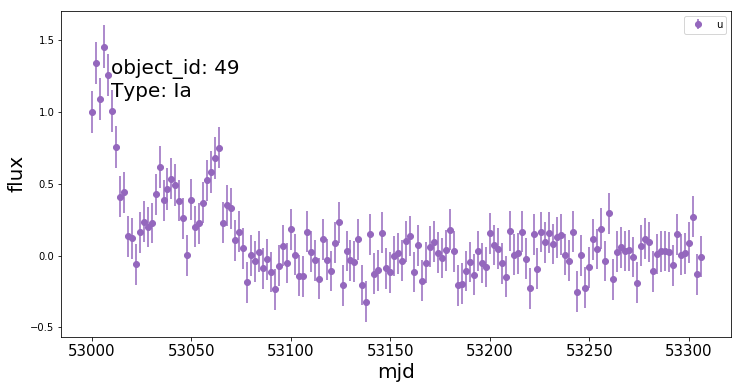

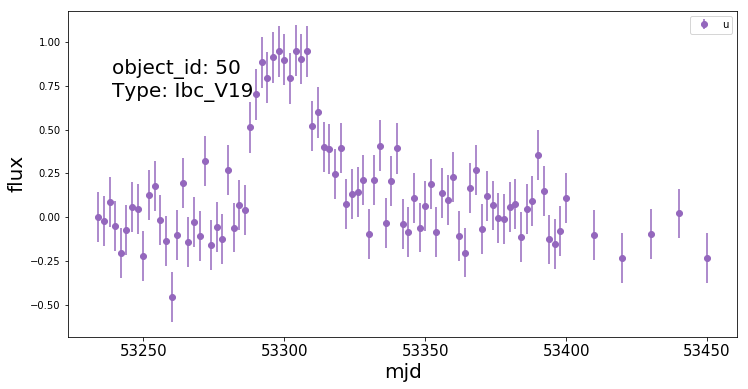

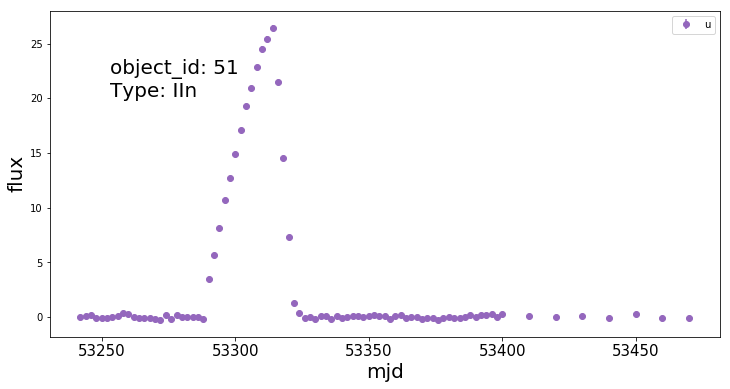

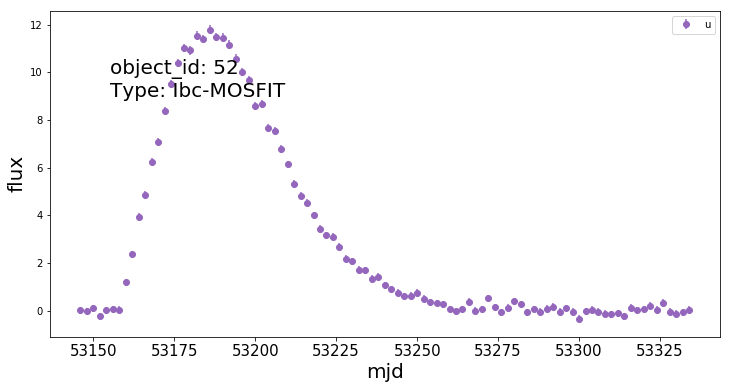

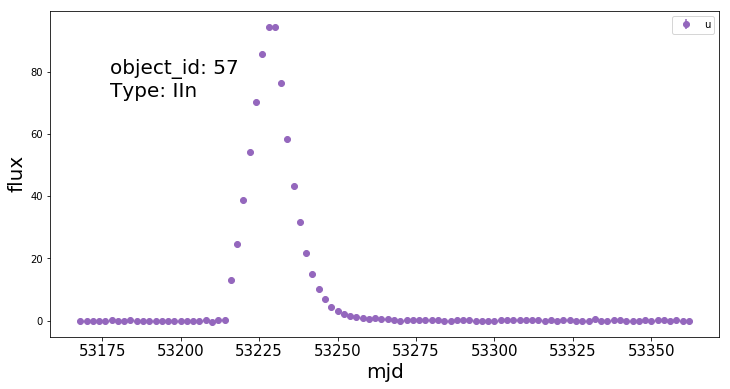

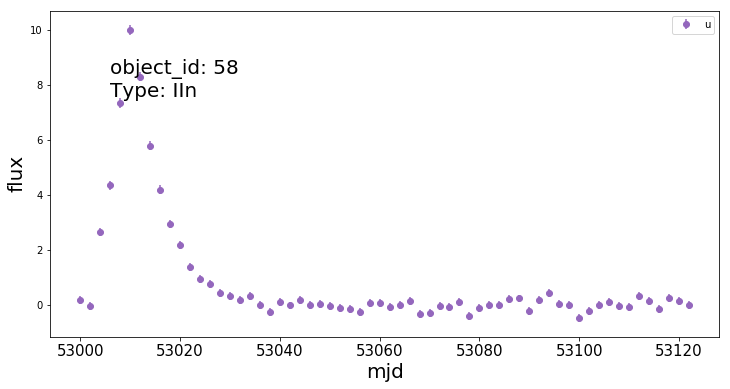

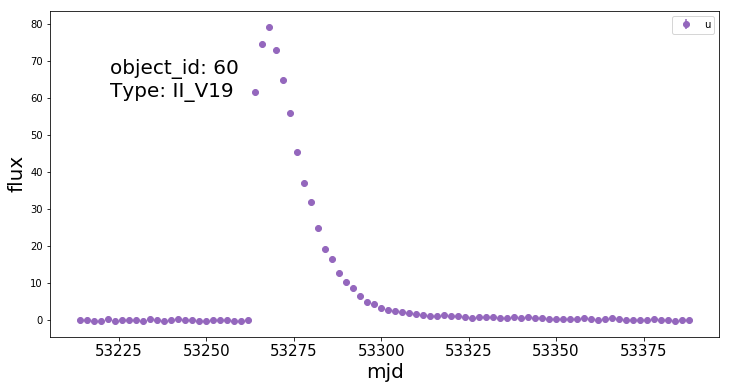

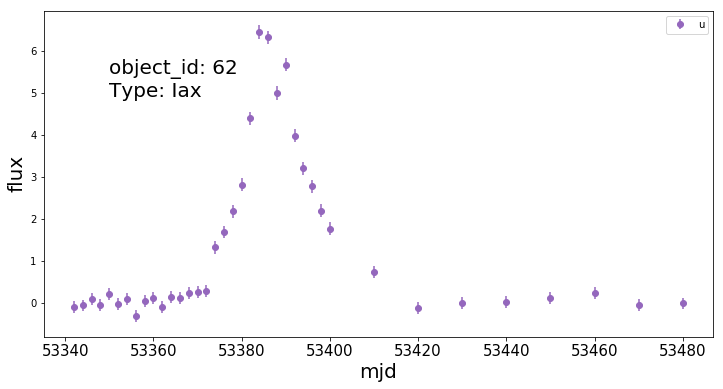

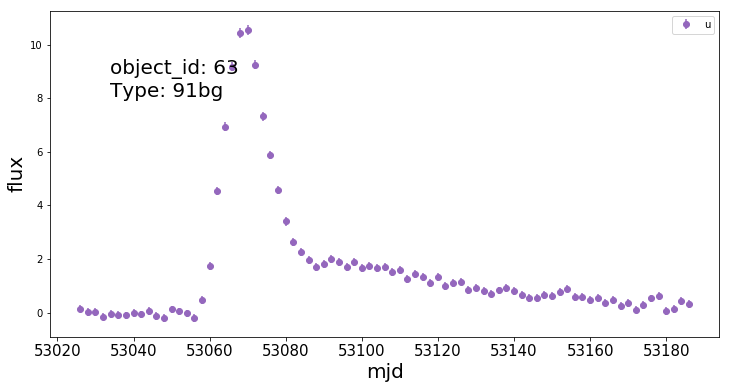

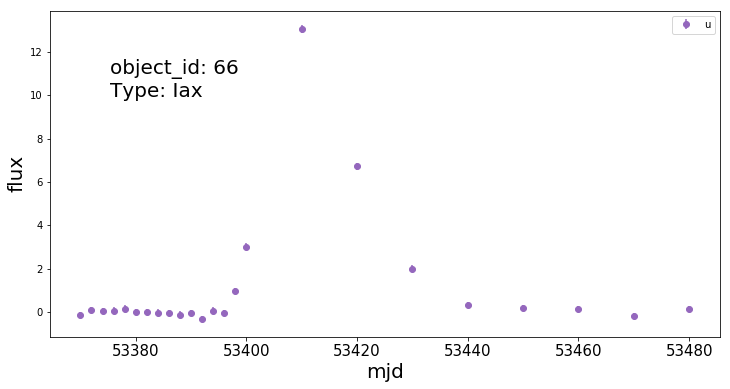

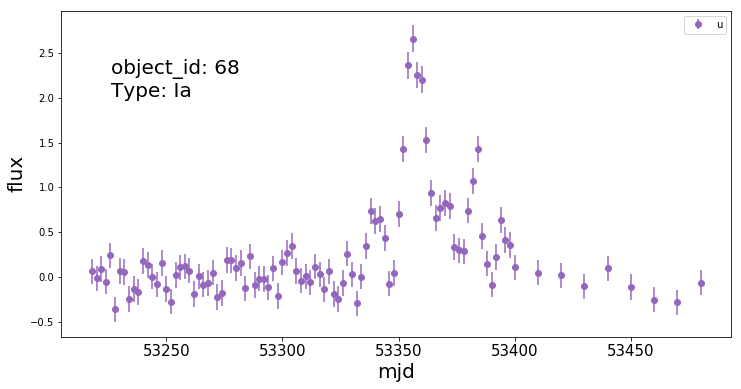

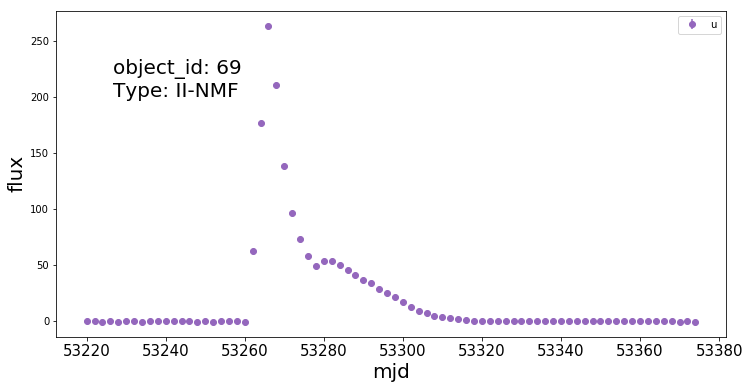

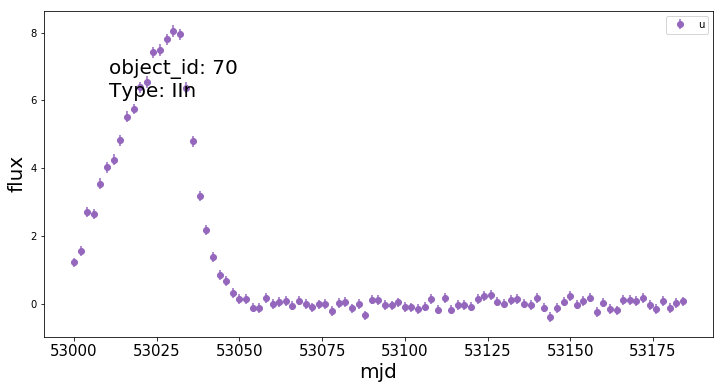

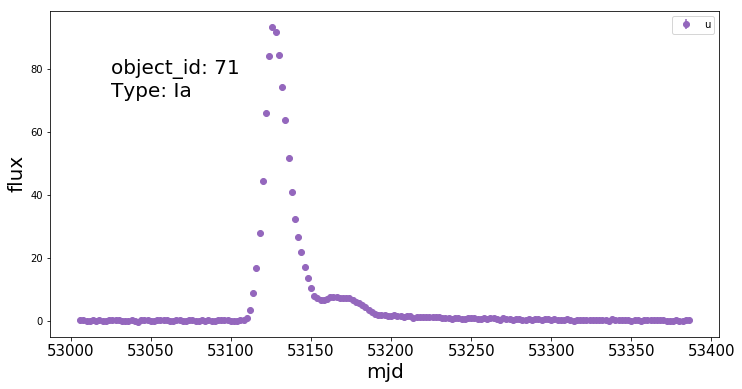

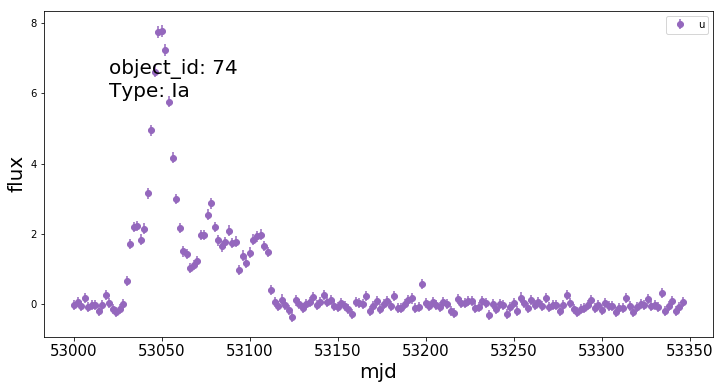

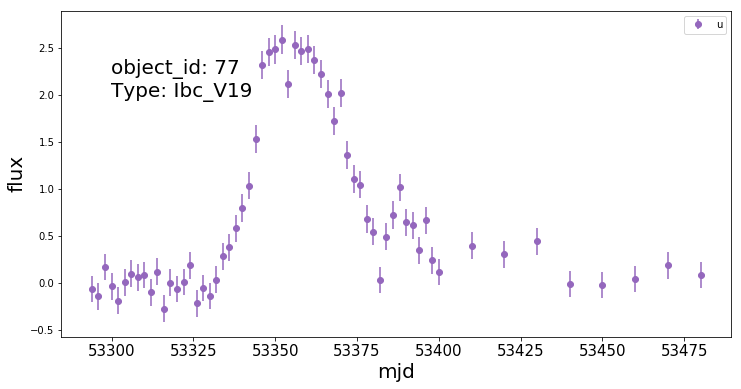

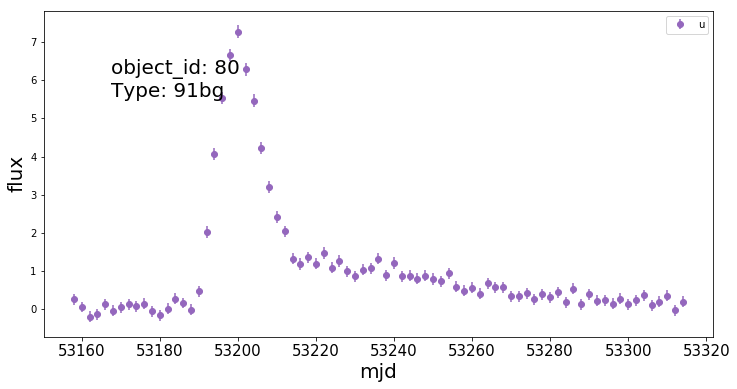

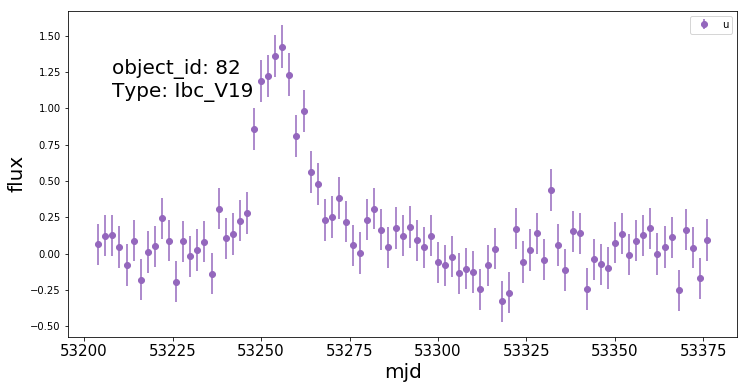

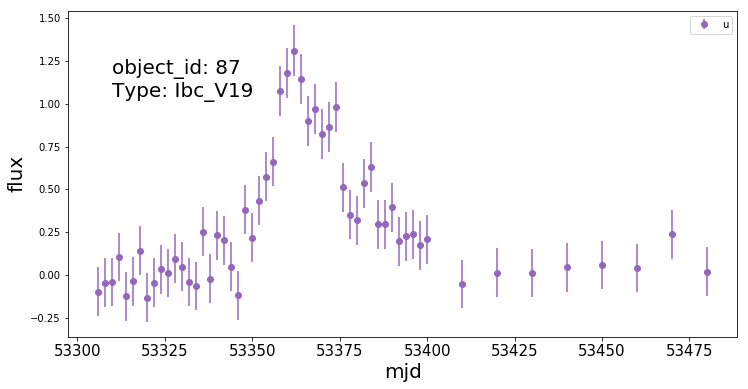

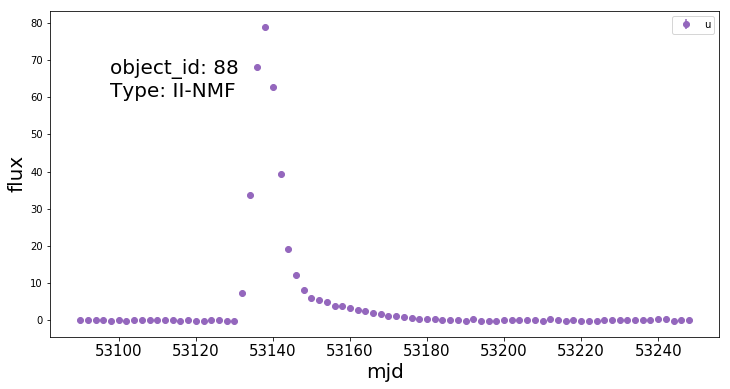

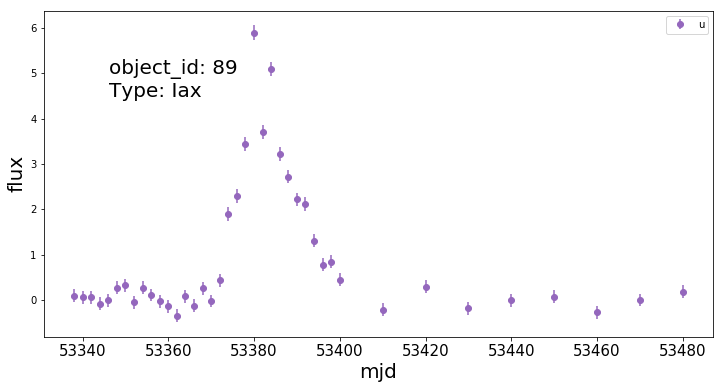

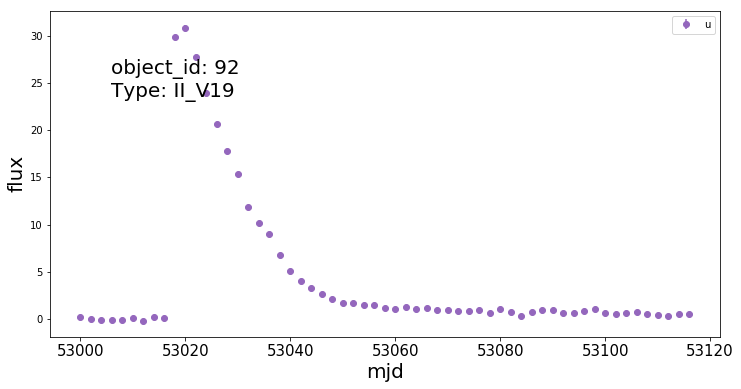

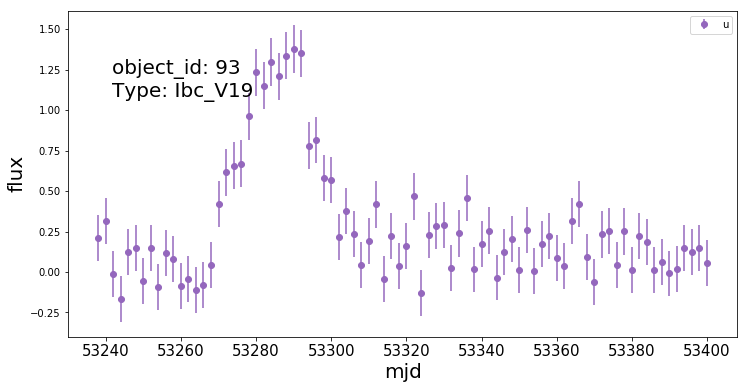

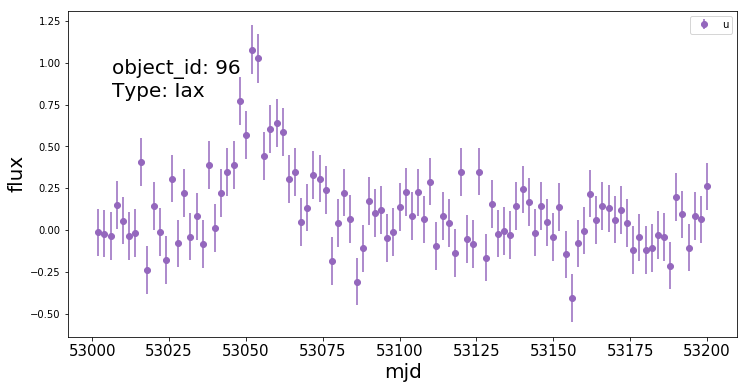

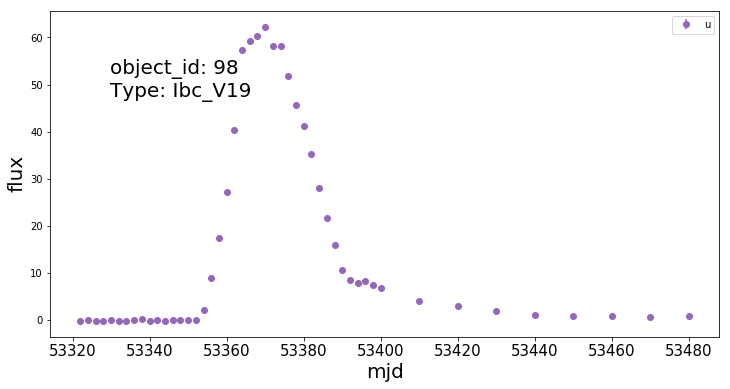

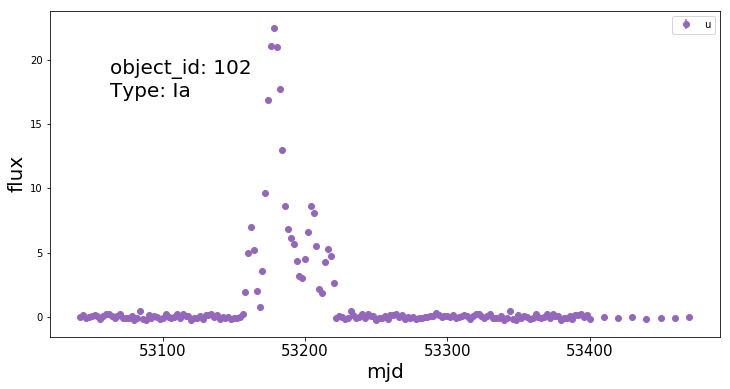

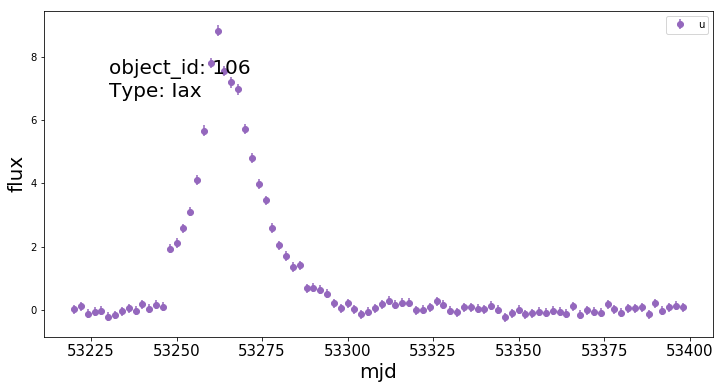

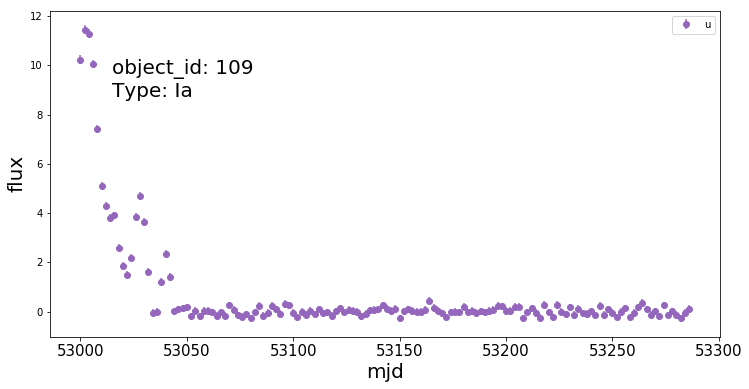

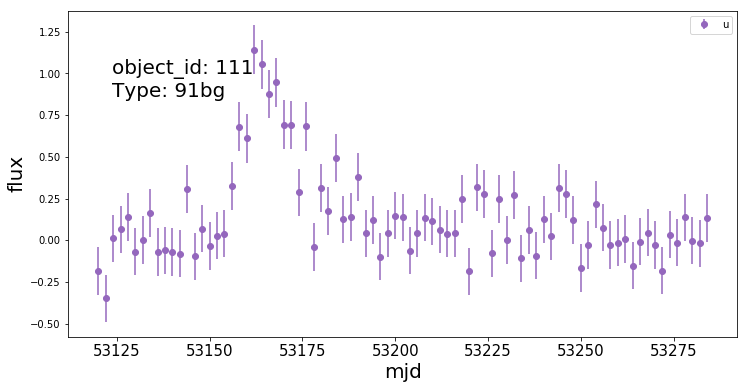

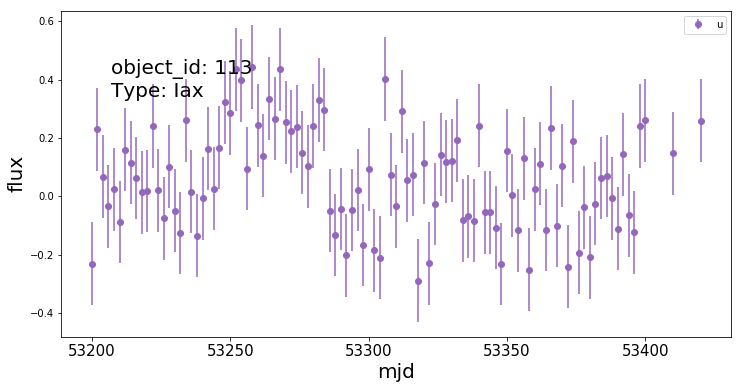

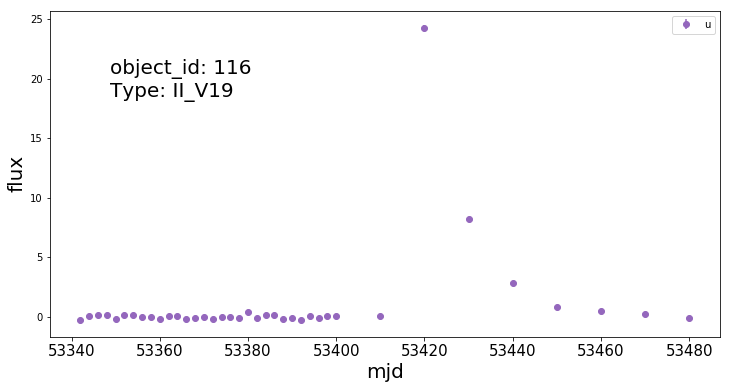

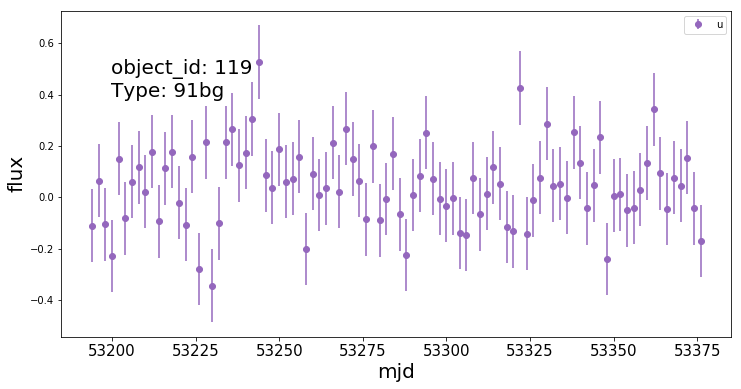

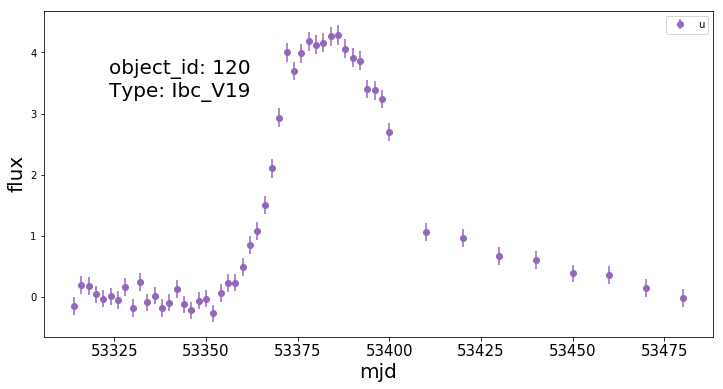

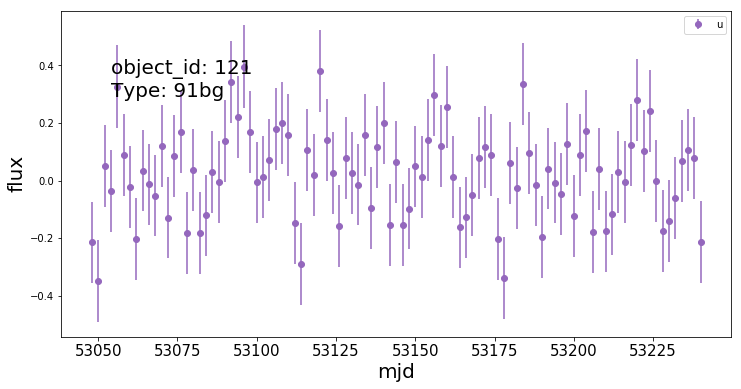

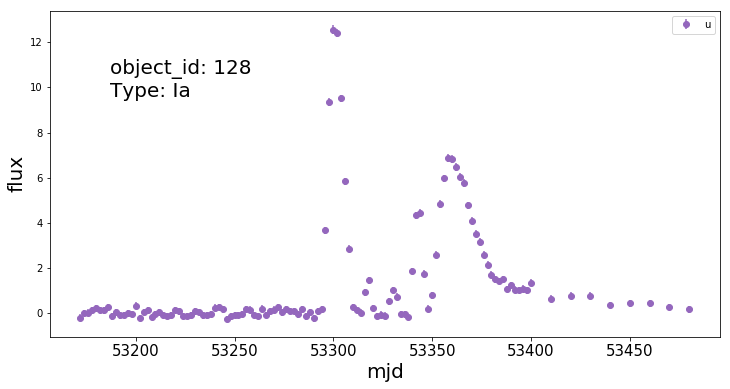

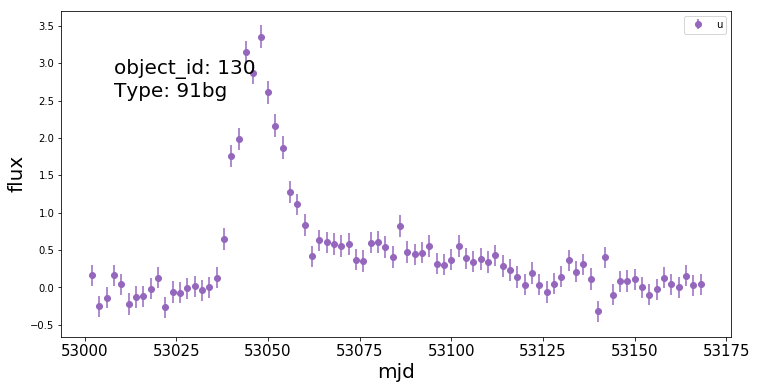

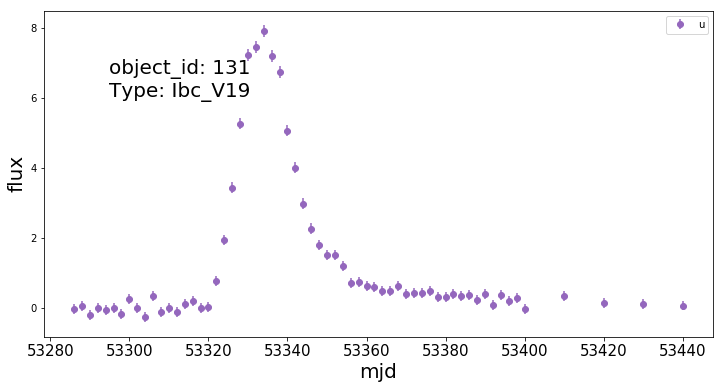

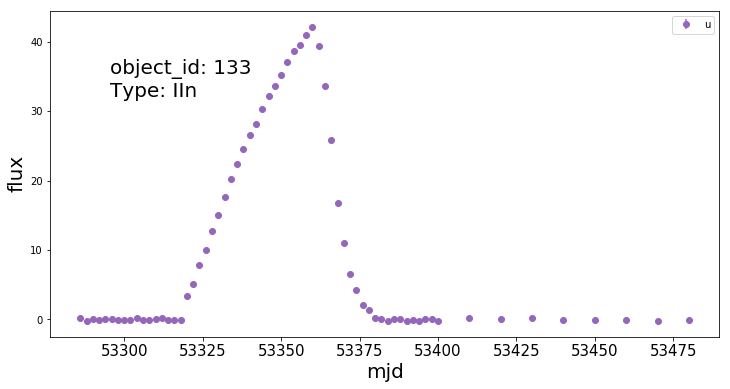

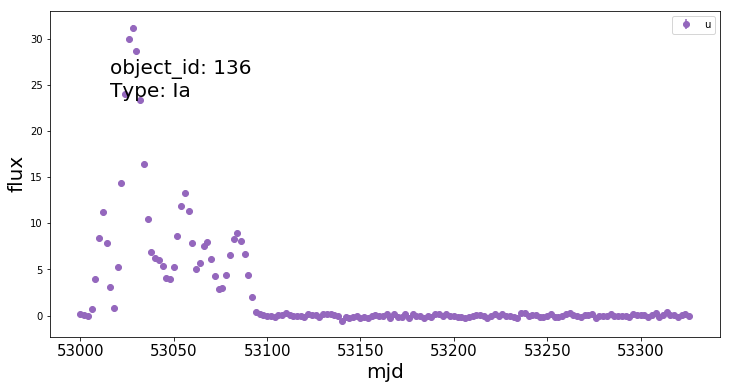

KeyboardInterrupt: 

In [15]:
for object_id in object_ids:
    lc = LightCurve(data_ob=data_ob, object_id=object_id)
    fig = lc.plot_light_curve(color_band_dict=color_band_dict, band ='u', mark_label=True, mark_maximum= False,plot_points =True)
    type_name = data_ob.df_metadata['type'][data_ob.df_metadata[data_ob.object_id_col_name] == object_id][0]
    plt.gca().annotate("object_id: "+str(int(object_id)), xy = (.15,.81), xycoords='figure fraction', fontsize=20)
    plt.gca().annotate("Type: "+type_name, xy = (.15,.75), xycoords='figure fraction', fontsize=20)
    plt.rc('xtick', labelsize = 15)
    fig.savefig("Perfect_plots/raw/id_"+str(int(object_id))+"_uband")
    plt.legend()
    plt.show()
    plt.close('all')

In [9]:
object_ids = np.sort(object_ids)

In [10]:
object_ids

array([2.000e+00, 3.000e+00, 4.000e+00, ..., 8.970e+03, 8.971e+03,
       8.973e+03])

In [16]:
from LightCurve import LightCurve

In [17]:
number_of_days_in_lc = 100
time_step=2

In [18]:
def get_alert_mid_pt(event_df, bands, current_date=None):
    
    if current_date is not None:
        date_difference = event_df[data_ob.time_col_name] - current_date
        past_index = (date_difference>=-50) & (date_difference<=0)
        event_df = event_df[past_index]
    
    band_mid_points = []
    for i,band in enumerate(bands):
        band_index = event_df[data_ob.band_col_name] == band
        band_df = event_df[band_index]
        
        PCs = np.load("PCs.npy")
        PCs = PCs[0:3]
        initial_guess = [.93,.03 ,.025]
        #regularization_base = [.93,.04,.012]
        if(len(band_df)>0):
            max_index = np.argmax(band_df[data_ob.flux_col_name])
            band_mid_points.append(band_df[data_ob.time_col_name][max_index])
    if len(band_mid_points)>0:
        return np.median(np.array(band_mid_points))
    else:
        return None

In [19]:
def gen_all_band_same_maxpt_PCs():

    final_array = {}
    for pb_name in data_ob.band_map.keys():
        final_array[pb_name] = np.zeros((len(object_ids),51))

    for i,object_id in enumerate(object_ids):
        event_df = data_ob.get_data_of_event(object_id)
        mid_point = get_alert_mid_pt(event_df, data_ob.band_map.keys())
        print(mid_point)
        fig , ax = plt.figure((12,6))
        if mid_point is not None:

            start_date = mid_point-number_of_days_in_lc/2
            end_date = mid_point+number_of_days_in_lc/2

            start_index = event_df['MJD']>= start_date
            end_index = event_df['MJD'] <= end_date

            df_within_date = event_df[start_index*end_index]

            for band in data_ob.band_map.keys():

                band_df = df_within_date[df_within_date[data_ob.band_col_name] == band]

                if len(band_df)>0:

                    rand_int = 0

                    shifted_flux = np.zeros_like(band_df['FLUXCAL'])
                    len_flux = len(band_df['FLUXCAL'])

                    if (rand_int>0)&(len_flux>rand_int):
                        shifted_flux[rand_int:len_flux] = band_df['FLUXCAL'][0:len_flux-rand_int]

                    elif (rand_int<0)&(rand_int>-len_flux-1):
                        shifted_flux[0:len_flux+rand_int] = band_df['FLUXCAL'][-rand_int:len_flux]

                    elif (rand_int==0):
                        shifted_flux = band_df['FLUXCAL']

                    else:
                        continue



                    max_loc = int((mid_point-np.amin(band_df['MJD']))/2)
                    flux_data = np.zeros((51))
                    flux_data[25-max_loc:25-max_loc+len(band_df['MJD'])] = shifted_flux
                    final_array[band][i] = flux_data
                    ax.scatter(np.arange(0,102,2), flux_data,
                                color=color_band_dict[band], label=str(band))
        else: 
            continue

    return fig   
        
        
        

In [21]:
def gen_all_band_diff_maxpt_PCs():
    final_array = {}
    for pb_name in data_ob.band_map.keys():
        final_array[pb_name] = np.zeros((len(object_ids),51))
        
    for i,object_id in enumerate(object_ids):
        print(object_id)
        event_df = data_ob.get_data_of_event(object_id)
        
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(1, 1, 1)
        for band in data_ob.band_map.keys():
            
            band_index = event_df[data_ob.band_col_name]==band
            band_df = event_df[band_index]
            
            if(len(band_df)>0):
                loc = np.argmax(band_df[data_ob.flux_col_name])
                mid_point = band_df[data_ob.time_col_name][loc]
                start_date = mid_point-number_of_days_in_lc/2
                end_date = mid_point+number_of_days_in_lc/2
                start_index = band_df['MJD']>= start_date
                end_index = band_df['MJD'] <= end_date


                band_df = band_df[start_index*end_index]
                if len(band_df)>0:
                    loc = np.argmax(band_df[data_ob.flux_col_name])
                    #rand_int = int(random()*5)-1
                    rand_int = 0

                    shifted_flux = np.zeros_like(band_df['FLUXCAL'])
                    len_flux = len(band_df['FLUXCAL'])

                    if (rand_int>0)&(len_flux>rand_int):
                        shifted_flux[rand_int:len_flux] = band_df['FLUXCAL'][0:len_flux-rand_int]

                    elif (rand_int<0)&(rand_int>-len_flux-1):
                        shifted_flux[0:len_flux+rand_int] = band_df['FLUXCAL'][-rand_int:len_flux]

                    elif (rand_int==0):
                        shifted_flux = band_df['FLUXCAL']

                    else:
                        continue

                    flux_data = np.zeros((51))
                    flux_data[25-loc:25-loc+len(band_df['MJD'])] = shifted_flux
                    final_array[band][i] = flux_data
                    x_data = np.arange(0,102,2)
                    print(np.argmax(flux_data))
                    if band == 'u':
                        ax.scatter(np.arange(0,102,2), flux_data, color=color_band_dict[band], label=band)
                    
                    
                    
                    
                    
        type_name = data_ob.df_metadata['type'][data_ob.df_metadata[data_ob.object_id_col_name] == object_id][0]
        plt.gca().annotate("object_id: "+str(int(object_id)), xy = (.15,.81), xycoords='figure fraction', fontsize=20)
        plt.gca().annotate("Type: "+type_name, xy = (.15,.75), xycoords='figure fraction', fontsize=20)
        ax.axvline(x=50,ymin=0,ymax=1,label="Day 50",linestyle = "--")
        plt.xlabel("Days", fontsize=20)
        plt.ylabel("Flux", fontsize=20)
        plt.rc("xtick", labelsize=15)
        ax.legend()
        fig.savefig("Perfect_plots/shifted/id_"+str(int(object_id))+"_uband")
        plt.show()
        plt.close('all')

                    
    return final_array

In [ ]:
object_ids = np.sort(object_ids)

In [ ]:
print(object_ids)

2.0
25
25
25
25
25
25


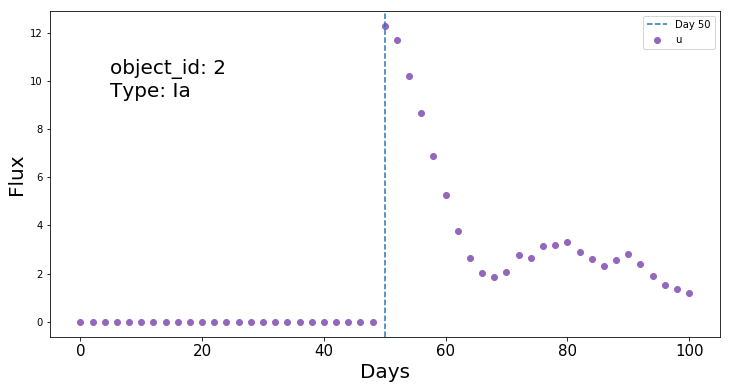

3.0
25
25
25
25
25
25


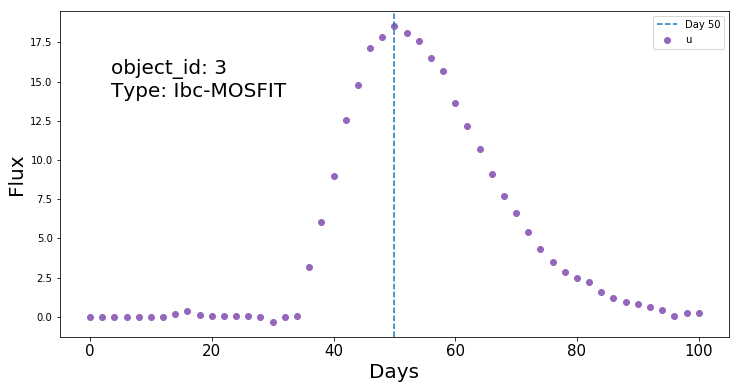

4.0
25
25
25
25
25
25


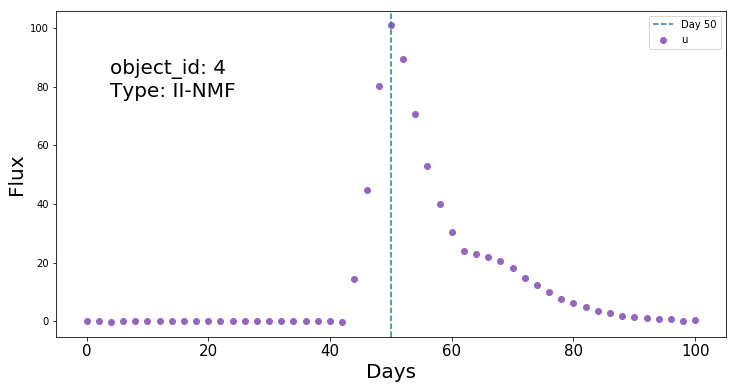

7.0
25
25
25
25
25
25


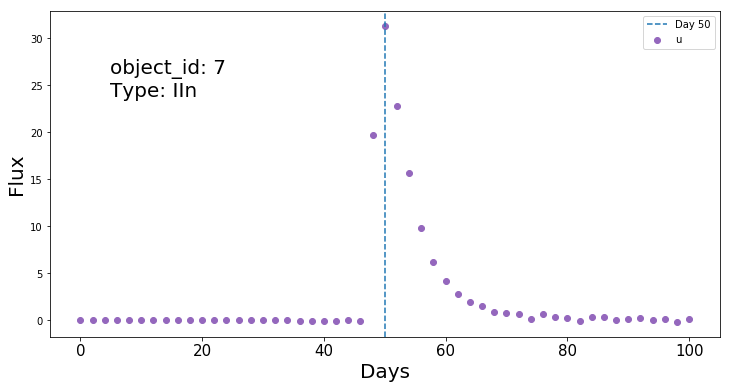

8.0
25
25
25
25
25
25


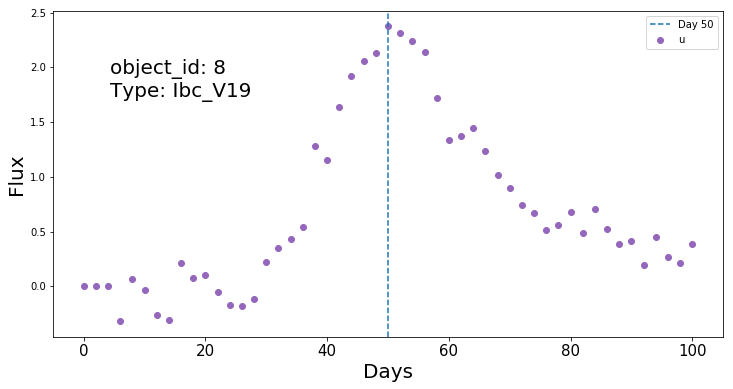

14.0
25
25
25
25
25
25


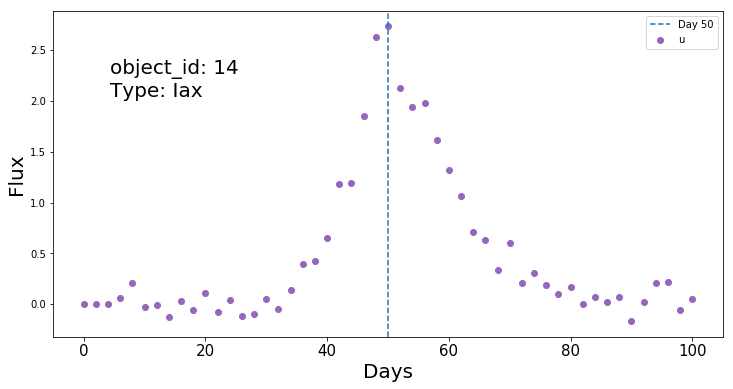

16.0
25
25
25
25
25
25


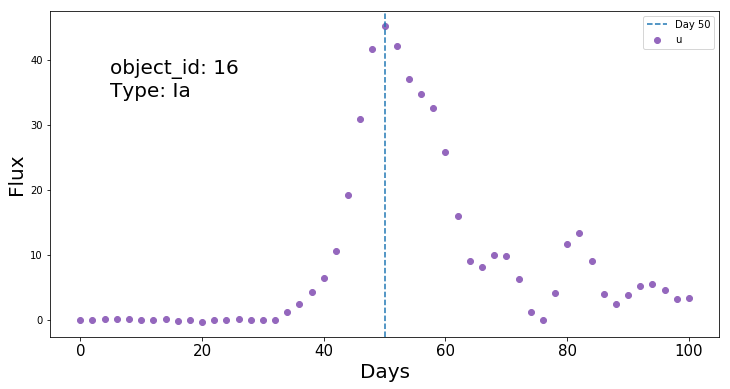

19.0
25
25
25
25
25
25


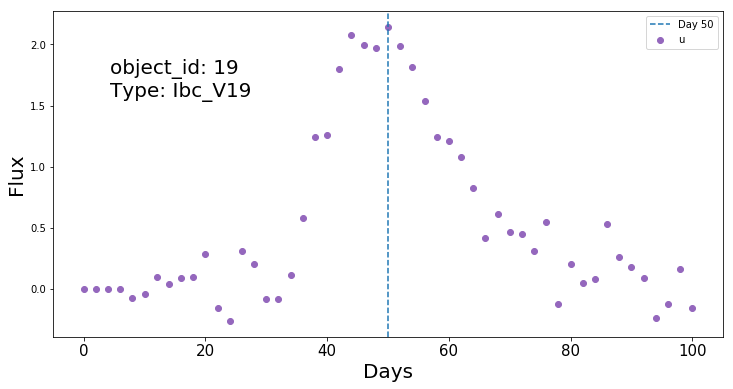

20.0
25
25
25
25
25
25


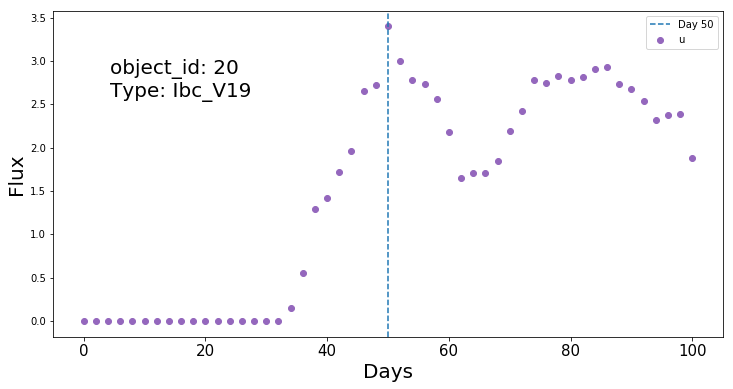

23.0
25
25
25
25
25
25


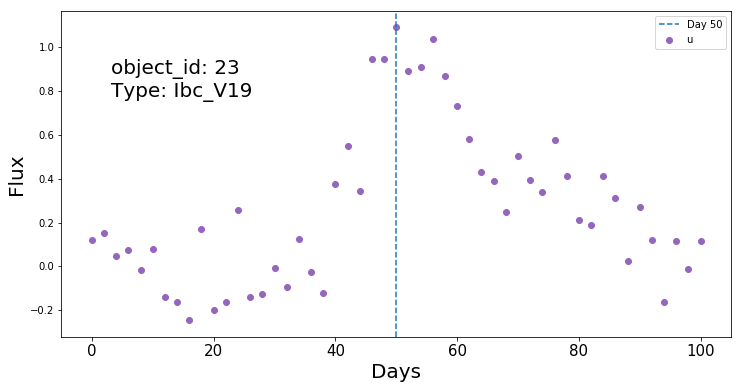

25.0
25
25
25
25
25
25


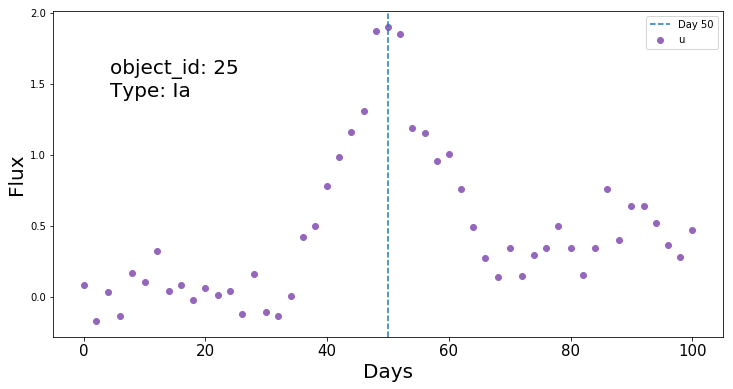

26.0
25
25
25
25
25
25


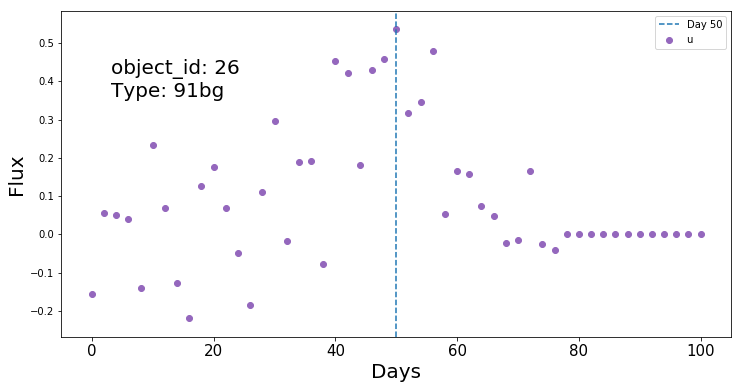

34.0
25
25
25
25
25
25


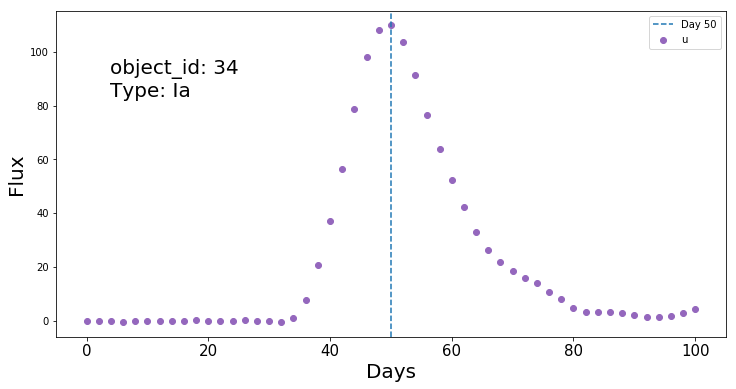

35.0
25
25
25
25
25
25


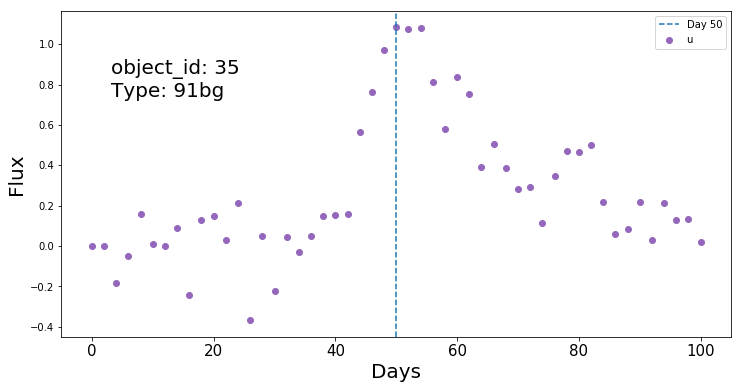

36.0
25
25
25
25
25
25


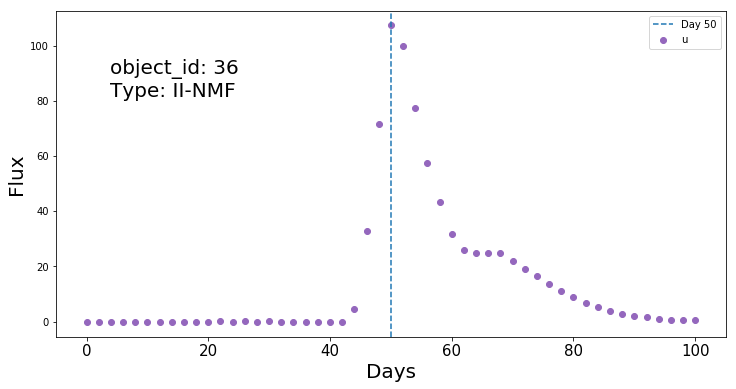

37.0
25
25
25
25
25
25


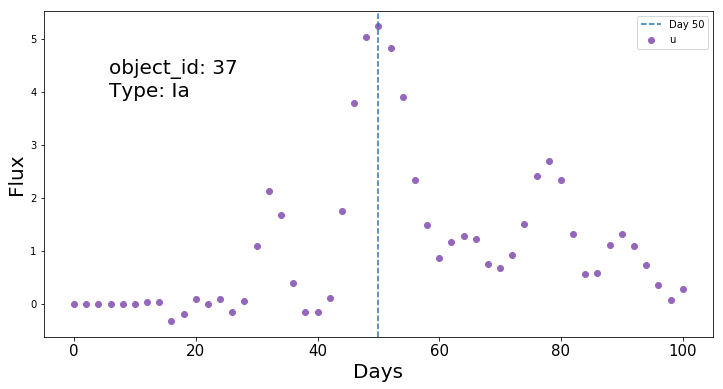

39.0
25
25
25
25
25
25


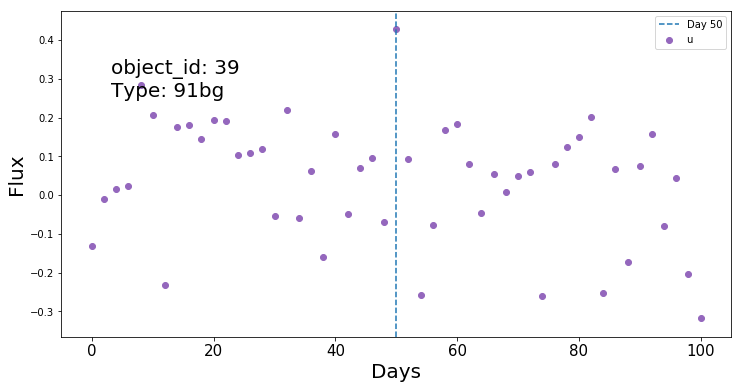

40.0
25
25
25
25
25
25


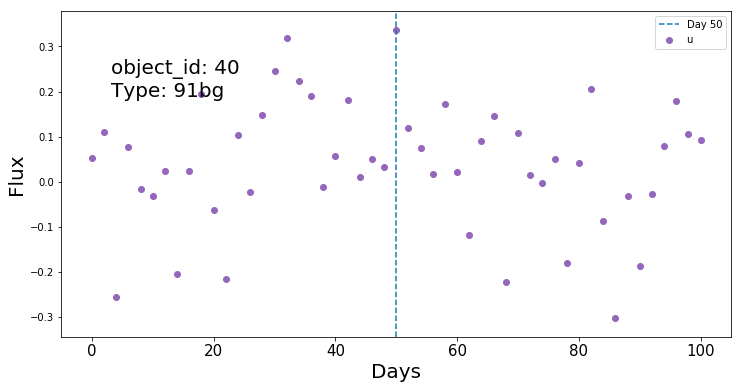

42.0
25
25
25
25
25
25


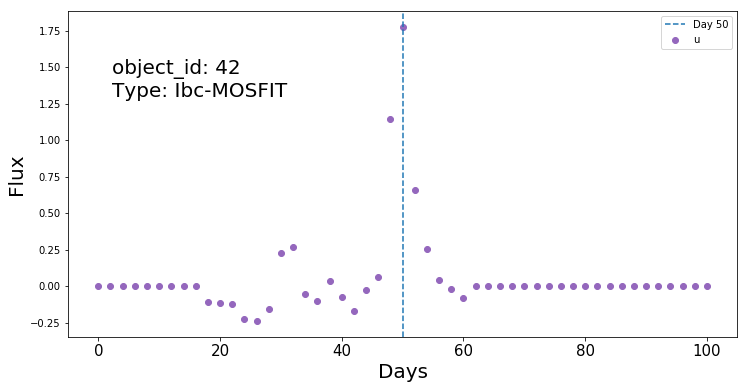

44.0
25
25
25
25
25
25


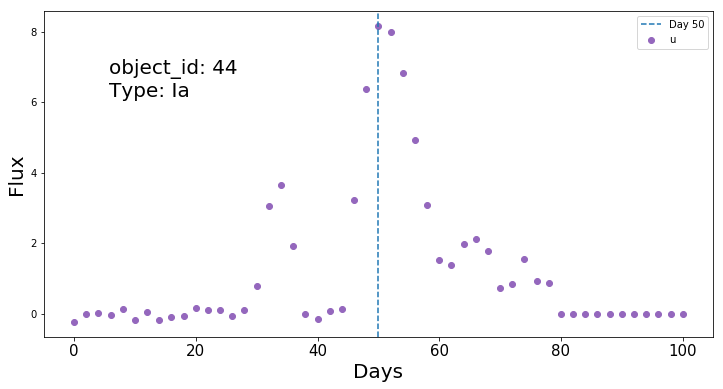

45.0
25
25
25
25
25
25


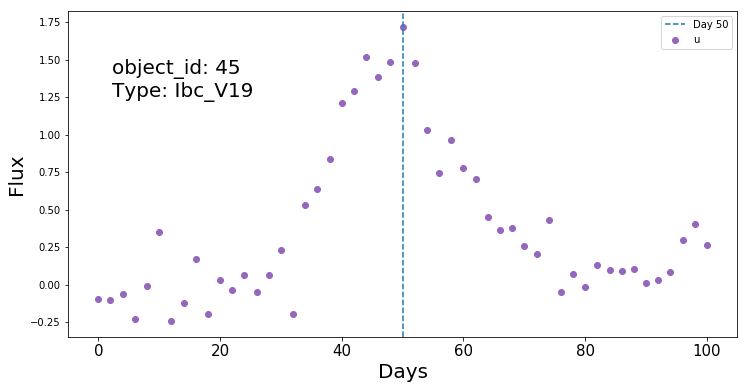

48.0
25
25
25
25
25
25


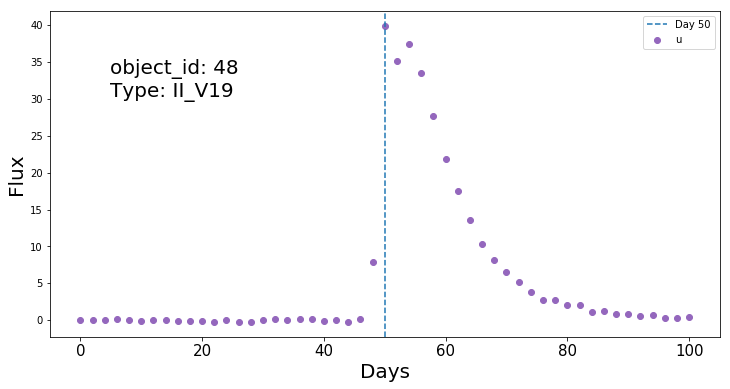

49.0
25
25
25
25
25
25


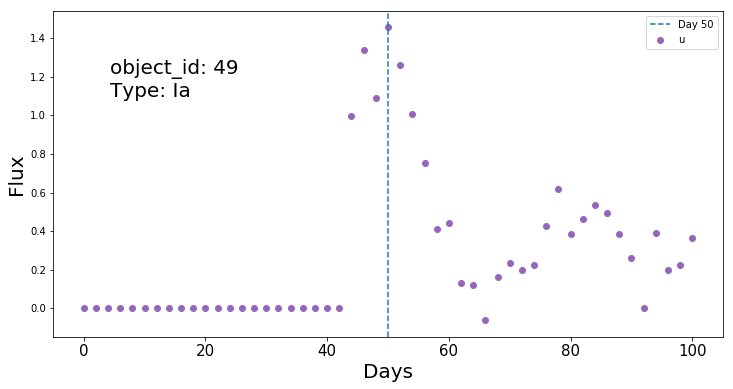

50.0
25
25
25
25
25
25


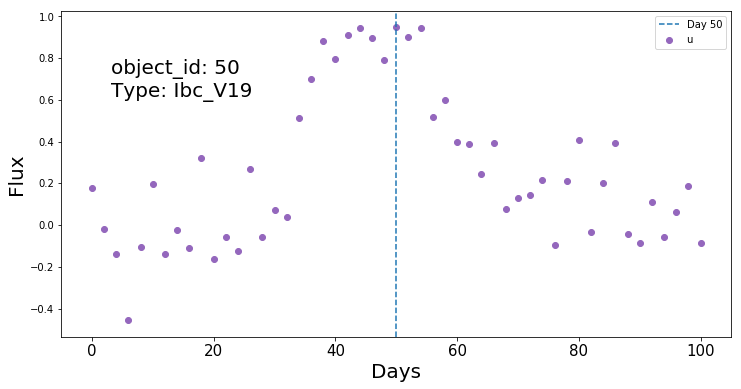

51.0
25
25
25
25
25
25


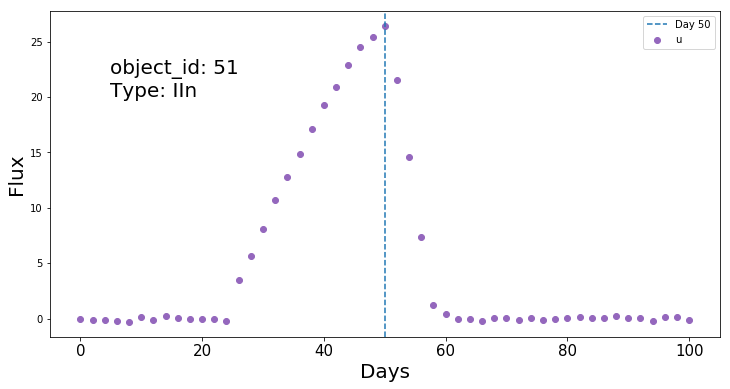

52.0
25
25
25
25
25
25


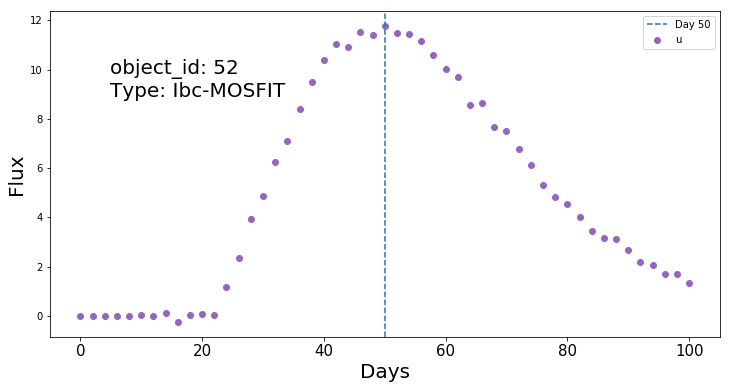

57.0
25
25
25
25
25
25


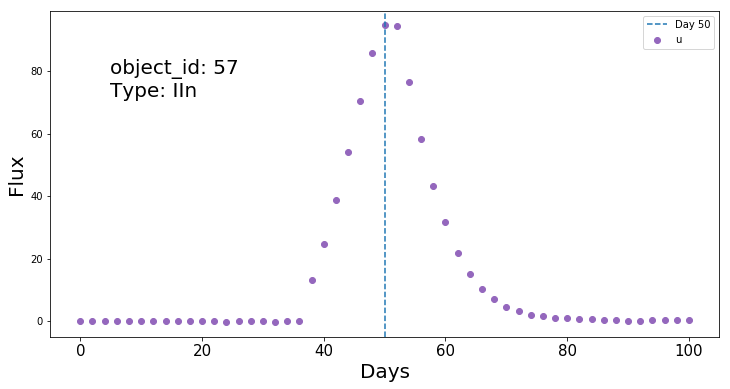

58.0
25
25
25
25
25
25


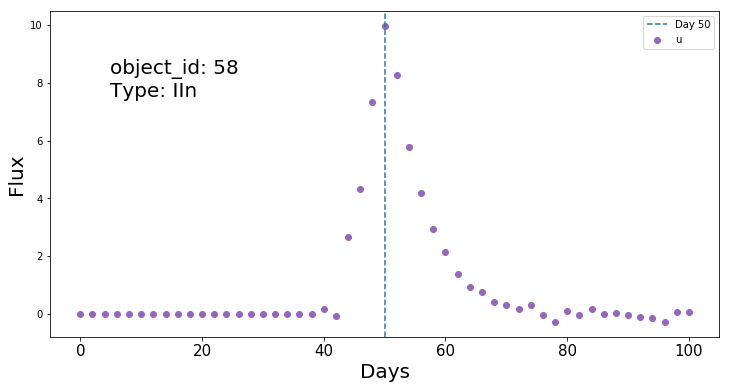

60.0
25
25
25
25
25
25


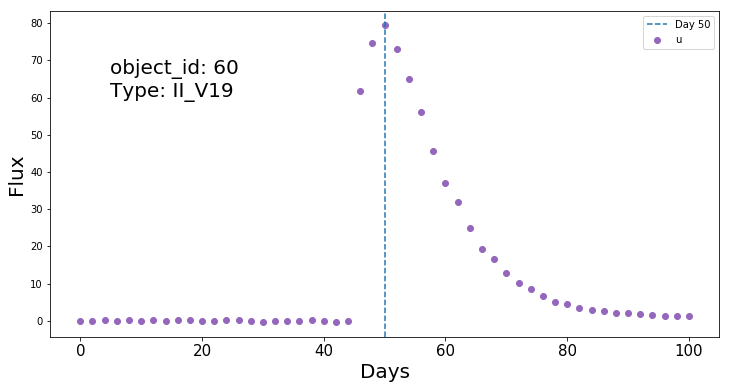

62.0
25
25
25
25
25
25


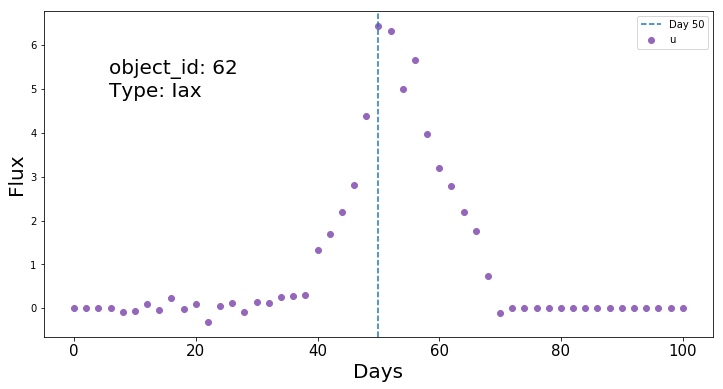

63.0
25
25
25
25
25
25


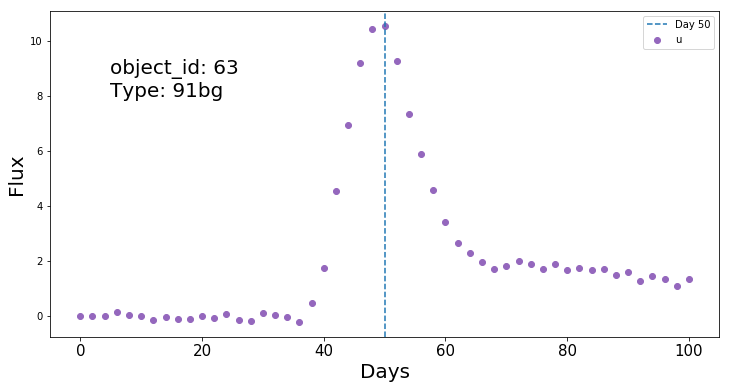

66.0
25
25
25
25
25
25


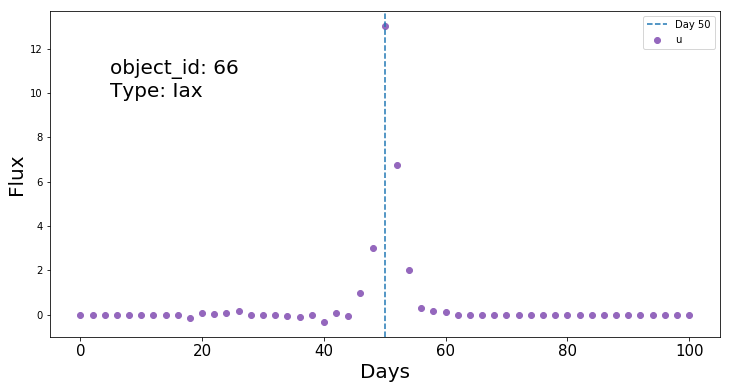

68.0
25
25
25
25
25
25


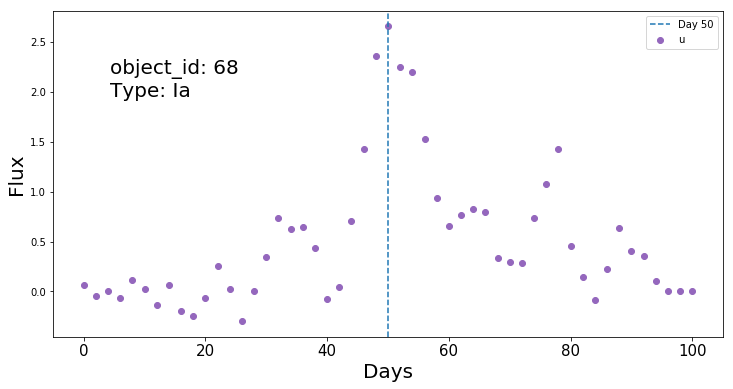

69.0
25
25
25
25
25
25


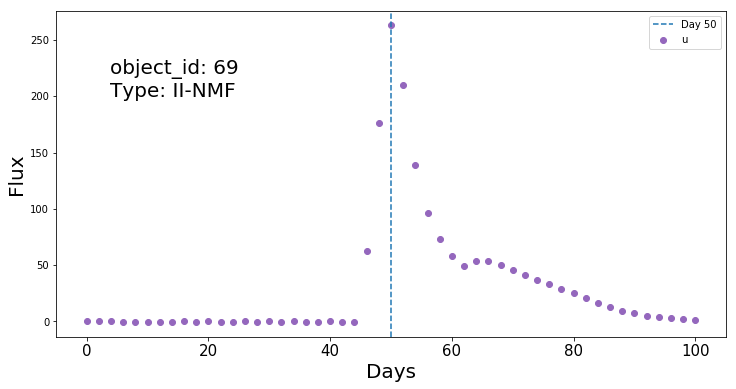

70.0
25
25
25
25
25
25


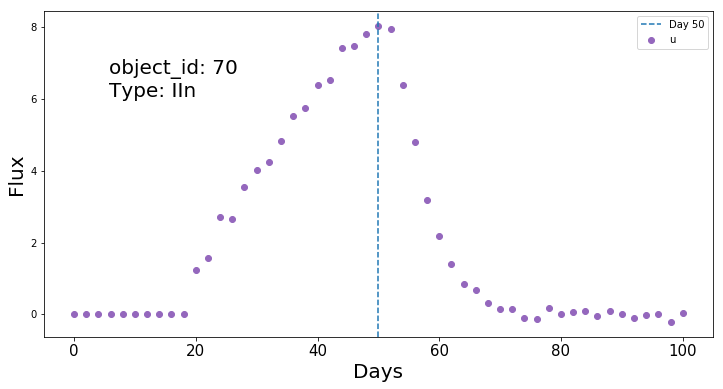

71.0
25
25
25
25
25
25


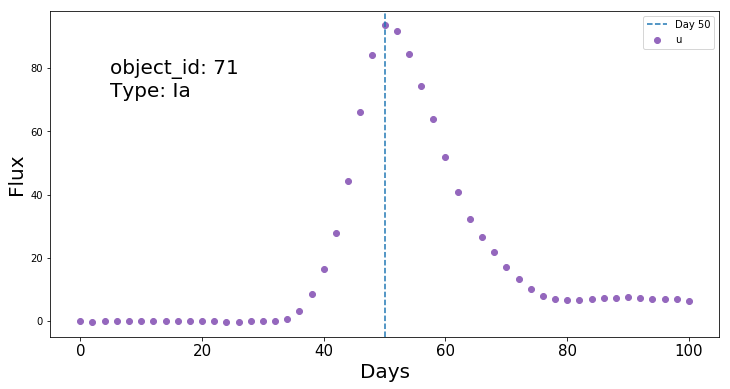

74.0
25
25
25
25
25
25


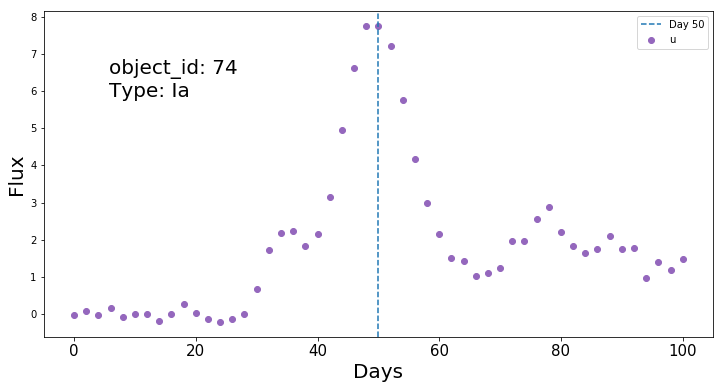

77.0
25
25
25
25
25
25


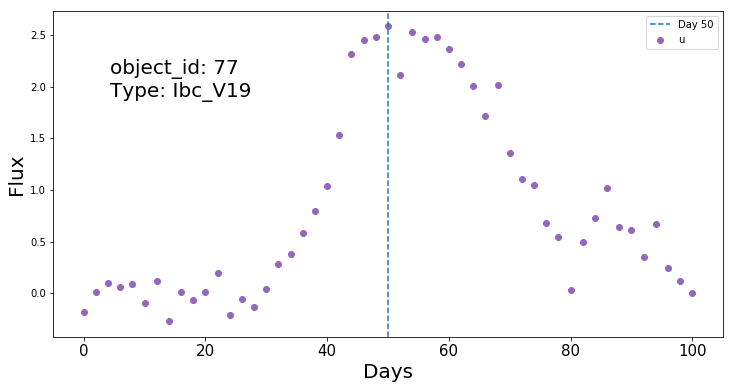

80.0
25
25
25
25
25
25


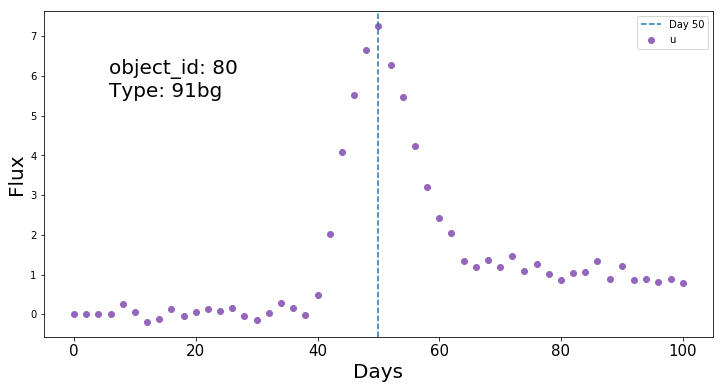

82.0
25
25
25
25
25
25


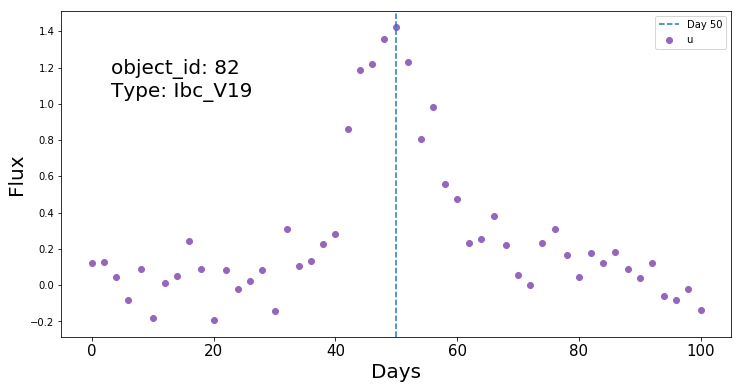

87.0
25
25
25
25
25
25


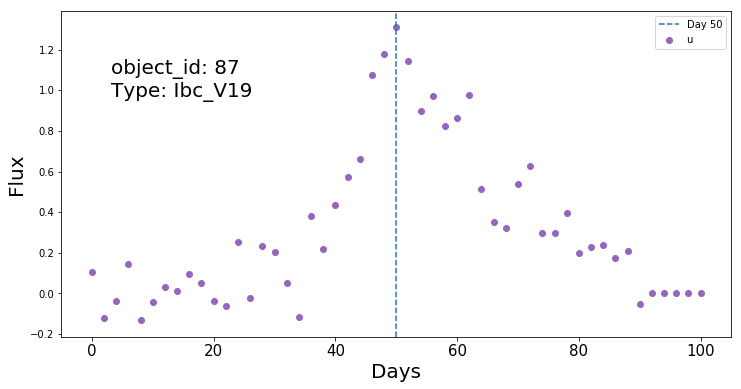

88.0
25
25
25
25
25
25


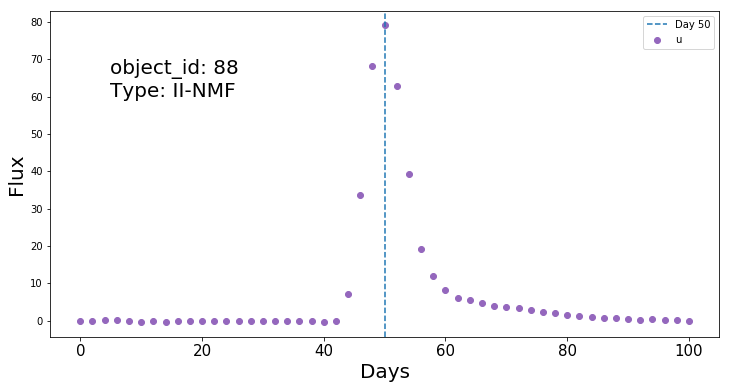

89.0
25
25
25
25
25
25


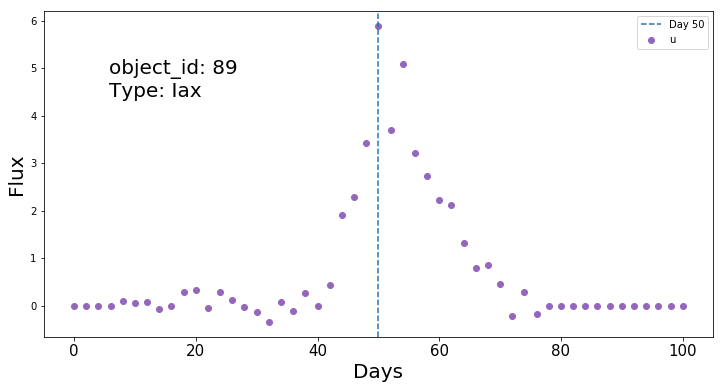

92.0
25
25
25
25
25
25


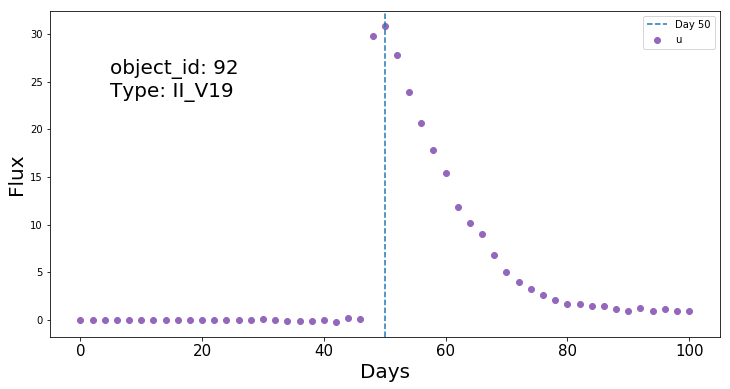

93.0
25
25
25
25
25
25


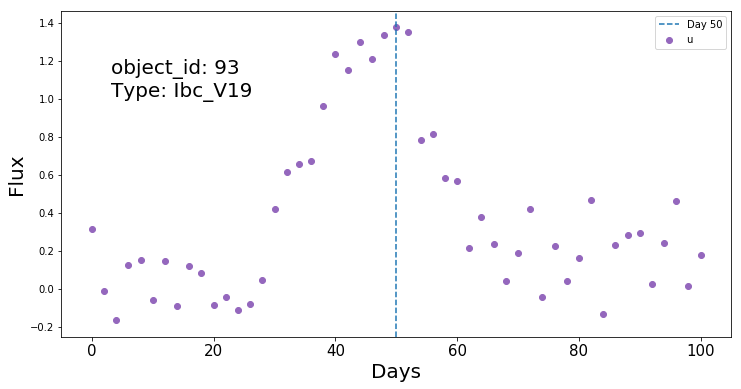

96.0
25
25
25
25
25
25


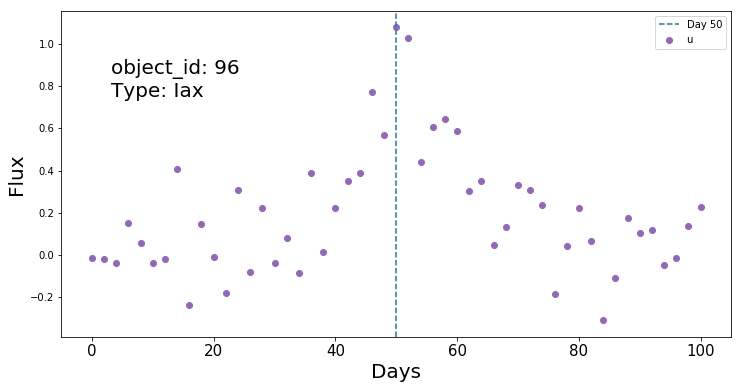

98.0
25
25
25
25
25
25


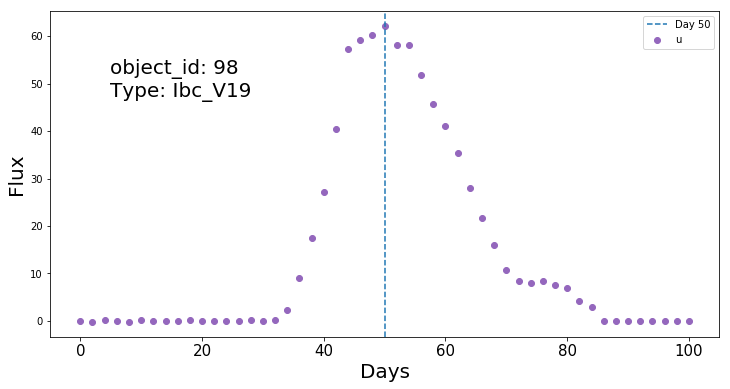

102.0
25
25
25
25
25
25


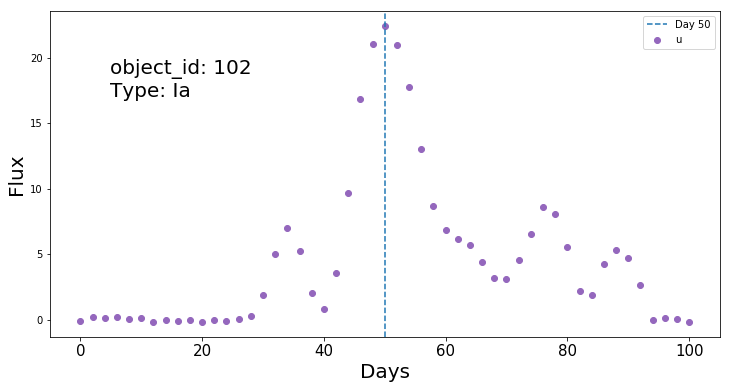

106.0
25
25
25
25
25
25


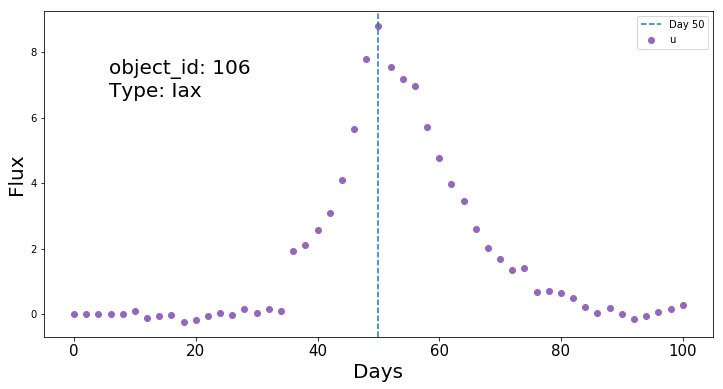

109.0
25
25
25
25
25
25


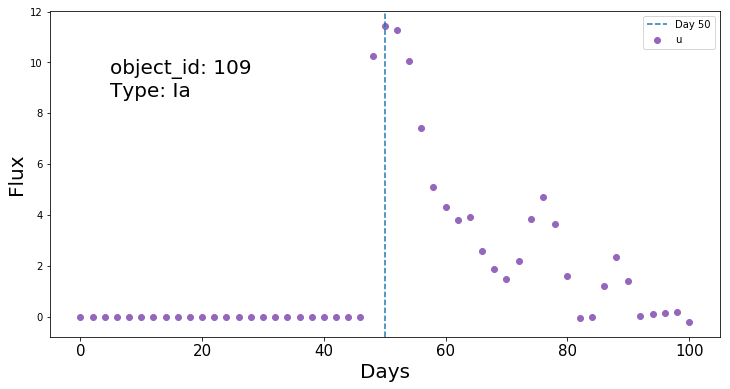

111.0
25
25
25
25
25
25


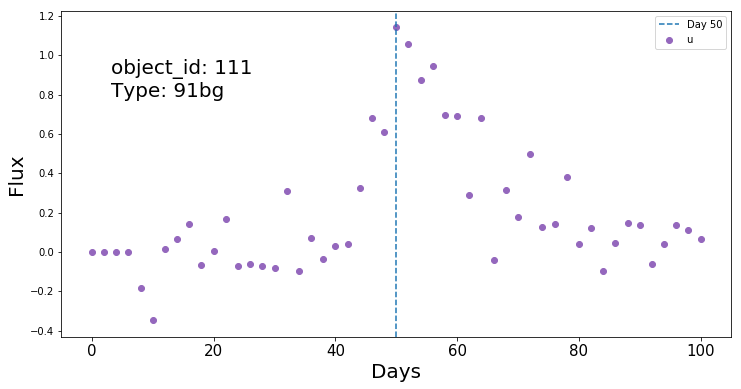

113.0
25
25
25
25
25
25


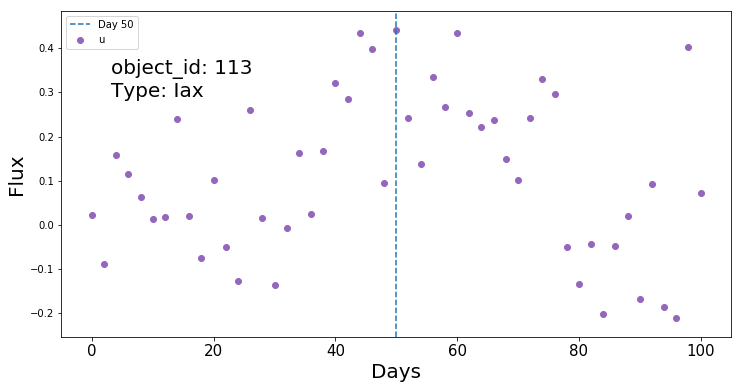

116.0
25
25
25
25
25
25


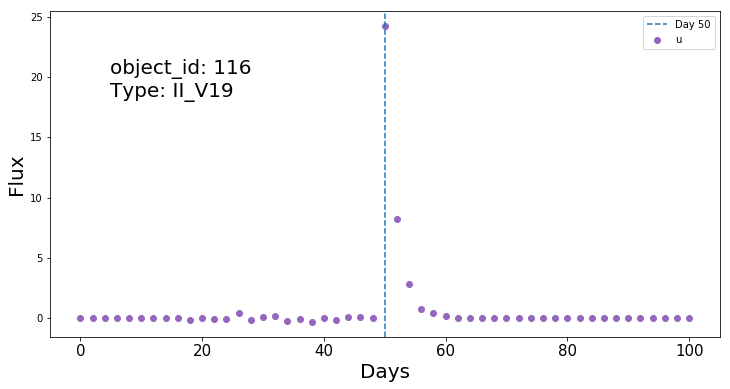

119.0
25
25
25
25
25
25


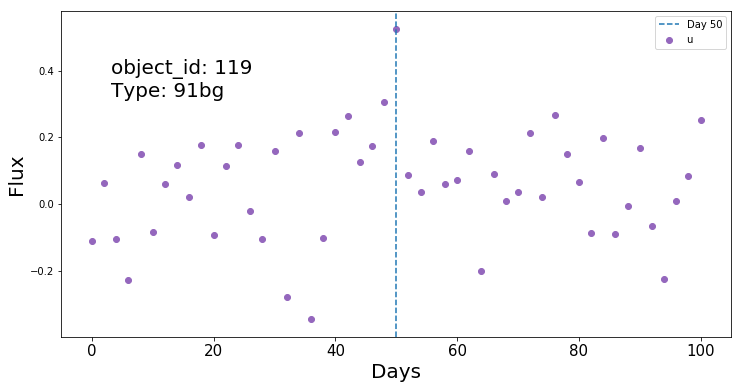

120.0
25
25
25
25
25
25


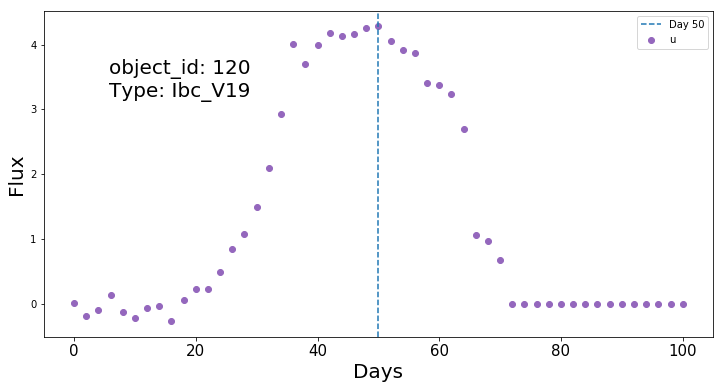

121.0
25
25
25
25
25
25


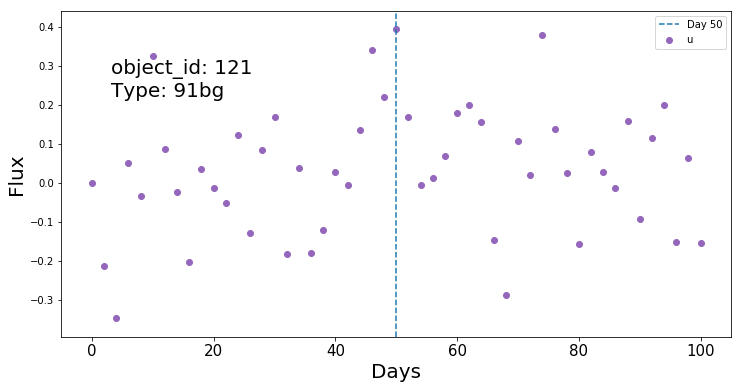

128.0
25
25
25
25
25
25


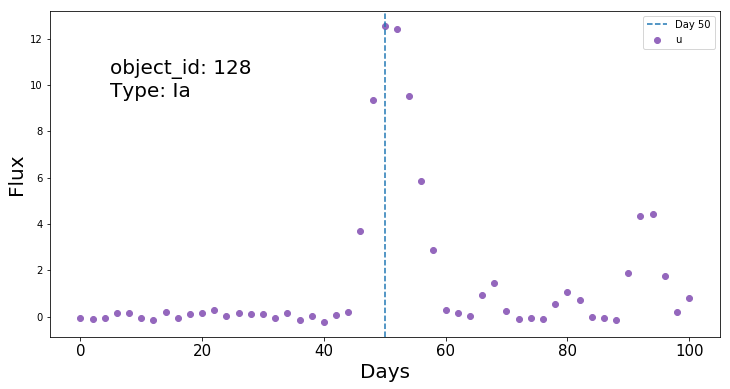

130.0
25
25
25
25
25
25


SystemError: <built-in method write of _io.BufferedWriter object at 0x7f7a6ac21d58> returned a result with an error set

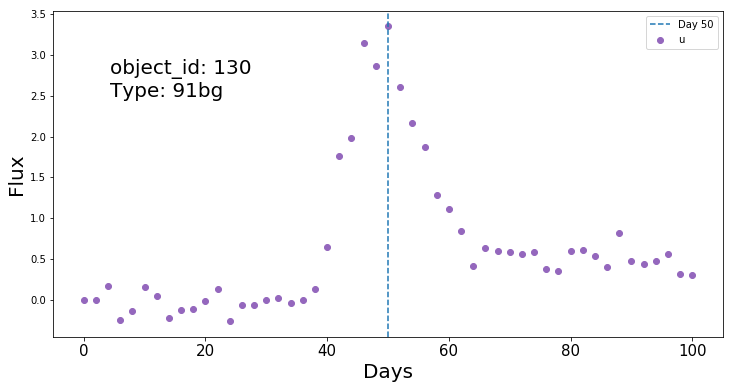

In [22]:
final_array = gen_all_band_diff_maxpt_PCs()
plt.show()
plt.close('all')
#print(final_array.keys())

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
color_band_dict['u']

In [ ]:
PC_dict = {}

for pb_name in data_ob.band_map.keys():
    pca = PCA(n_components=10)
    pca.fit(final_array[pb_name])
    PC_dict[pb_name] = pca.components_
    print(PC_dict[pb_name].shape)
    del pca

In [ ]:
print(PC_dict.keys())

In [ ]:
data_ob.band_map.keys()

In [ ]:
for band in data_ob.band_map.keys():
    print(band)
    PCs= PC_dict[band]
    fig = plt.figure(figsize=(10,5))
    for i in range(3):
        PC = PCs[i]
        x = np.arange(0,102,2)
        plt.plot(x,PC,marker='o',label = "PC "+str(i+1))

    plt.xlabel("days", fontsize = 20)
    plt.ylabel("Coefficients of PCs", fontsize=20)
    print(band)
    plt.legend()
    plt.title("Plot of Coefficients of PCs",fontsize=30)
    #fig.savefig("Plot of PCs")
    plt.show()

In [ ]:
#np.save("principal_components/PC_all_bands_diff_mid_pt_dict", PC_dict)

In [ ]:
print(PC_dict['u'][0:3])

In [ ]:
for object_id in object_ids:
    event_df = data_ob.get_data_of_event(object_id)
    lc = LightCurve(data_ob.get_data_of_event(object_id), time_col_name=data_ob.time_col_name, brightness_col_name=data_ob.flux_col_name, brightness_err_col_name=data_ob.flux_err_col_name,band_col_name=data_ob.band_col_name, band_map=data_ob.band_map)
    fig = lc.plot_light_curve(color_band_dict, alpha = 1)
    plt.show()
    plt.close('all')
    
    

In [ ]:
num_of_elements=51
final_array = np.zeros((len(object_ids),num_of_elements))

for j in range(10):
    
    for i,object_id in enumerate(objects_ids):
        #print(i)
        ob_list = []
        object_mask = df['SNID']==object_id
        object_df = df[object_mask]


        #for band in filters.keys():

        band_mask = object_df['FLT'] == 'r'
        band_df = object_df[band_mask]

        index_of_maximum = np.argmax(band_df['FLUXCAL'])
        date_of_maximum = band_df['MJD'][index_of_maximum]
        #print(date_of_maximum)

        start_date = date_of_maximum-50
        end_date = date_of_maximum+50 

        start_index = band_df['MJD']>= start_date
        end_index = band_df['MJD'] <= end_date

        df_within_date = band_df[start_index*end_index]
        #print(df_within_date['MJD'])
        max_loc = np.argmax(df_within_date['FLUXCAL'])
        max_flux = df_within_date['FLUXCAL'][max_loc]
        rand_int = int(random()*5)+4
        #rand_int = 7
        #rand_int = 0
        shifted_flux = np.zeros_like(df_within_date['FLUXCAL'])
        len_flux = len(df_within_date['FLUXCAL'])
        if (rand_int>0)&(len_flux>rand_int):
            shifted_flux[rand_int:len_flux] = df_within_date['FLUXCAL'][0:len_flux-rand_int]
            
            
        elif (rand_int<0)&(rand_int>-len_flux-1):
            shifted_flux[0:len_flux+rand_int] = df_within_date['FLUXCAL'][-rand_int:len_flux]

            
        elif (rand_int==0):
            shifted_flux = df_within_date['FLUXCAL']
        
        else:
            continue

        #print(max_loc)
        flux_data = np.zeros((num_of_elements))
        flux_data[25-max_loc:25-max_loc+len(df_within_date['MJD'])] = shifted_flux
        final_array[i] = flux_data
        print(np.argmax(flux_data))
        
        x = np.arange(51)-26
        #plt.plot(x,flux_data)
        #plt.show()
        #plt.close()
        



In [ ]:
x = np.arange(51)-26
plt.xlabel("time")
plt.ylabel("Normalized flux")
plt.plot(x,final_array[1]/np.amax(final_array[1]))
print(final_array[1])

In [ ]:
print(len(objects_ids))

In [ ]:
pca = PCA(n_components=10)

In [ ]:
pca.fit(final_array)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca.singular_values_

In [ ]:
PCs = pca.components_

In [ ]:
PCs = np.load("principal_components/PC_all_bands_diff_mid_pt_dict.npy")

In [ ]:
PCs = PCs.item()

In [ ]:
PCs['u'][0:3].shape

In [ ]:
print(PCs['g'].shape)

In [ ]:
fig = plt.figure(figsize=(10,5))
for i in range(3):
    PC = PCs[i]
    x = np.arange(0,102,2)
    plt.plot(x,PC,marker='o',label = "PC "+str(i+1))

plt.xlabel("days", fontsize = 20)
plt.ylabel("normalized flux", fontsize=20)
    
plt.legend()
plt.title("Plot of Coefficients of PCs",fontsize=30)
fig.savefig("Plot of PCs")
plt.show()

In [ ]:
np.save("principal_components/PCs_shifted",pca.components_)